In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from collections import Counter

# NLP and Text Processing
import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import cmudict
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import textstat
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Scikit-learn
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report

# Local
from classes.song import Song
from classes.playlist import Playlist
from classes.spotify_manager import SpotifyManager
from classes.lyrics_manager import LyricsManager
from classes.utils import gather_data_from_folders
from classes.stats import BootstrapEvaluator
from classes.model_pipeline import OptimalClassificationPipeline, OptimalRegressionPipeline

import warnings
warnings.simplefilter('ignore')
load_dotenv();

# Loading the data

In [5]:
df = pd.read_pickle(os.path.join('datasets', "final_data.pkl"))
print(f"Loaded {df.shape[0]} songs")
df.head()

Loaded 5387 songs


id                  title             artist  \
0  4RL77hMWUq35NYnPLXBpih            skinny love              birdy   
1  5PsjZ21f5tMPFf1sJpokm7              deathwish     red sun rising   
2  6vrUTGn5p8IrfTZ0J6sIVM                   iris  the goo goo dolls   
3  0Leo4GP0UKG4tUABm9JATe  don't dream it's over      crowded house   
4  0It6VJoMAare1zdV2wxqZq    undisclosed desires               muse   

                                       album_art_url  popularity explicit  \
0  https://i.scdn.co/image/ab67616d0000b2733661c0...        70.0        0   
1  https://i.scdn.co/image/ab67616d0000b273612f16...         NaN        0   
2  https://i.scdn.co/image/ab67616d0000b273d54c4b...        71.0        0   
3  https://i.scdn.co/image/ab67616d0000b27380ed24...         NaN        0   
4  https://i.scdn.co/image/ab67616d0000b273b6d456...        65.0        0   

   album_release_year  duration_ms  \
0                2011       201080   
1                2018       287946   
2                2007       289906   
3                2017       231377   
4                2009       235000   

                                              genres  \
0              ['neo mellow', 'uk pop', 'viral pop']   
1                ['modern hard rock', 'post-grunge']   
2  ['neo mellow', 'permanent wave', 'pop rock', '...   
3              ['australian rock', 'permanent wave']   
4  ['alternative rock', 'modern rock', 'permanent...   

                                              lyrics  ... dale_chall  \
0  come skinni love last year pour littl salt nev...  ...      10.78   
1  life fleet slow chill us wave feed bone right ...  ...      10.55   
2  id give forev touch caus know feel somehow you...  ...      11.16   
3  freedom within freedom without tri catch delug...  ...      12.27   
4  know youv suffer dont want hide cold loveless ...  ...      11.77   

   vader_compound  noun_ratio verb_ratio  language sentiment_polarity  \
0          0.9738    0.506173   0.246914   english           0.276623   
1          0.9758    0.340426   0.191489   english           0.128397   
2         -0.8865    0.390476   0.323810   english          -0.259184   
3         -0.9549    0.460317   0.277778   english           0.581746   
4          0.4822    0.448276   0.252874   english          -0.162245   

   sentiment_subjectivity  type_token_ratio  repetition_count  \
0                0.670563          0.691358                25   
1                0.563763          0.260638               139   
2                0.447959          0.428571                60   
3                0.379894          0.484127                65   
4                0.591270          0.494253                44   

                                 preprocessed_lyrics  
0  come skinni love last year pour littl salt nev...  
1  life fleet slow chill us wave feed bone right ...  
2  id give forev touch caus know feel somehow clo...  
3  freedom within freedom without tri catch delug...  
4  know youv suffer dont want hide cold loveless ...  

[5 rows x 179 columns]

In [6]:
df['popularity_imputed'] = 0
df.loc[df.popularity.isna(), 'popularity_imputed'] = 1
df.loc[df.popularity.isna(), 'popularity']  = df[~df.popularity.isna()].popularity.median()

In [7]:
df.popularity_imputed.value_counts()

popularity_imputed
0    4856
1     531
Name: count, dtype: int64

In [8]:
spotify_features = ['popularity', 'explicit',
       'album_release_year', 'duration_ms', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature']

lyrics_features = ['unique_word_count',
       'sentiment_polarity', 'sentiment_subjectivity', 'noun_ratio',
       'verb_ratio', 'vader_compound', 'repetition_count', 'language', 'genre',
       'lexical_richness', 'semantic_depth', 'syntactic_complexity',
       'rhyme_density', 'sentiment_variability', 'linguistic_uniqueness',
       'flesch_reading_ease', 'gunning_fog', 'dale_chall', 'type_token_ratio', 'word_count']

tfidf_features = [ f for f in df.columns if f.startswith("tfidf_") ]


audio_extracted_features = ['mfcc_1', 'mfcc_2',
       'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9',
       'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'chroma_1', 'chroma_2',
       'chroma_3', 'chroma_4', 'chroma_5', 'chroma_6', 'chroma_7', 'chroma_8',
       'chroma_9', 'chroma_10', 'chroma_11', 'chroma_12',
       'spectral_contrast_1', 'spectral_contrast_2', 'spectral_contrast_3',
       'spectral_contrast_4', 'spectral_contrast_5', 'spectral_contrast_6',
       'spectral_contrast_7', 'tempo_extracted', 'zcr']

<Axes: xlabel='genre'>

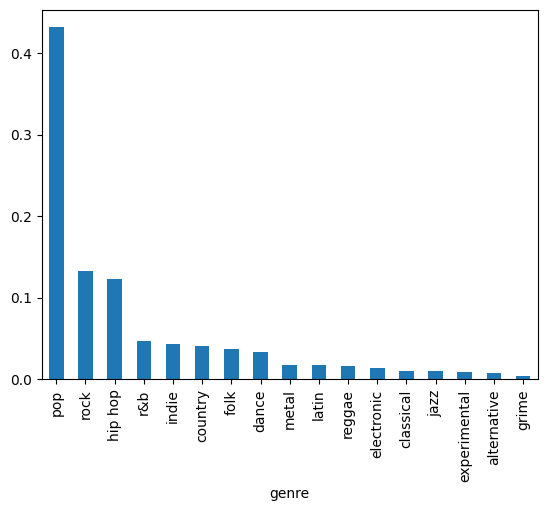

In [7]:
df.genre.value_counts(normalize=True).plot(kind='bar')

## 1. Correlation Heatmap
Purpose:
The correlation heatmap is used to visualize the pairwise correlation between multiple numerical features in your dataset. It helps identify which features are highly correlated with each other.

How It Works:

Correlation measures the strength of a linear relationship between two variables. The most common method is Pearson correlation, where values range from -1 to 1:
1 means perfect positive correlation.
-1 means perfect negative correlation.
0 means no correlation.
In your analysis, you calculated the correlation matrix, which shows correlations for all features, and then filtered for correlations above a threshold (e.g., 0.5).
The heatmap is a graphical representation where color intensity reflects the strength of the correlation.
Conclusion:
From your correlation heatmap, you likely identified pairs or groups of features that are strongly correlated (for example, duration_ms and syllable_count). These insights can inform feature selection or suggest which features might introduce redundancy into models. It also helps to reduce multicollinearity when building models.



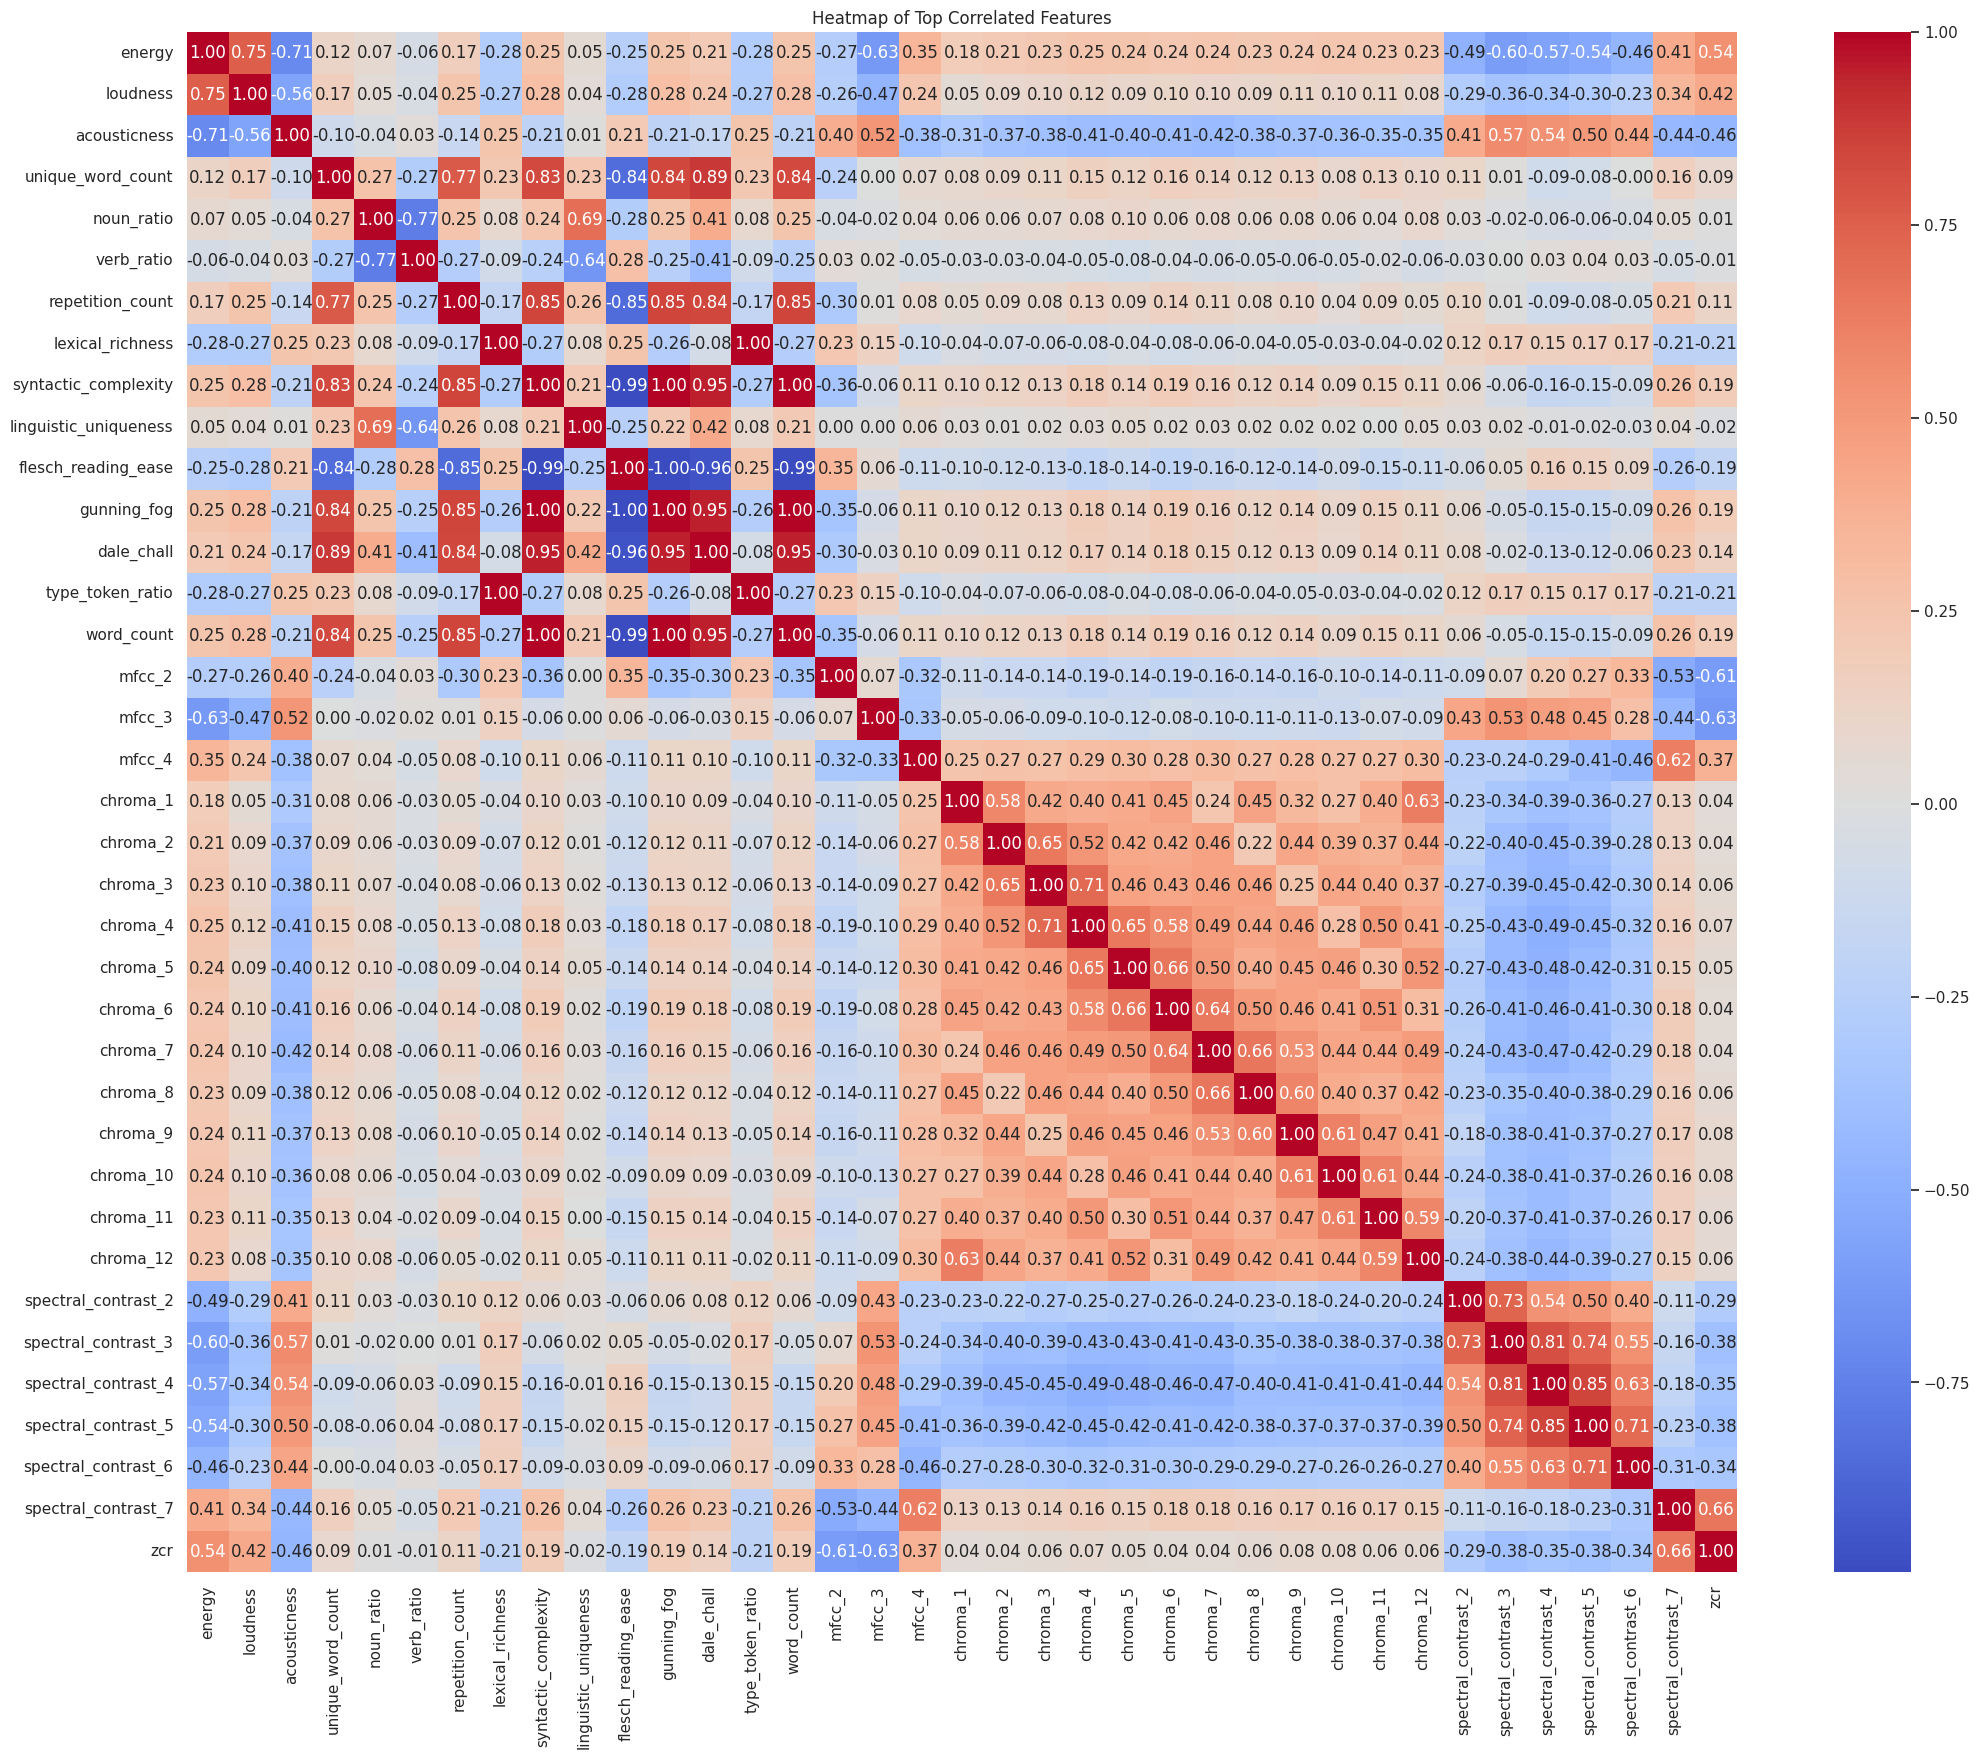

In [272]:
num_df = df[spotify_features + lyrics_features + audio_extracted_features].dropna().select_dtypes(include=[np.number])

corr_matrix = num_df.corr()

high_corr_features = corr_matrix[corr_matrix.abs() > 0.6].stack().reset_index()
high_corr_features = high_corr_features[high_corr_features['level_0'] != high_corr_features['level_1']]

top_corr_features = pd.unique(high_corr_features[['level_0', 'level_1']].values.ravel('K'))

plt.figure(figsize=(25, 20))
sns.heatmap(num_df[top_corr_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Top Correlated Features', fontsize=12)
plt.show()

## 2. Hierarchical Clustering (Dendrogram)
Purpose:
Hierarchical clustering groups similar features based on their pairwise correlations, visualized using a dendrogram. This technique helps in clustering features into groups that are highly correlated, reducing dimensionality or simplifying feature analysis.

How It Works:

The dendrogram is built using agglomerative clustering, where each feature starts in its own cluster, and the most similar clusters are merged at each step. This continues until all features are grouped into a single cluster.
The Ward linkage method was used, which minimizes the variance within clusters.
The vertical axis represents the distance (or dissimilarity) between clusters. The longer the vertical lines between two clusters, the more dissimilar they are.
Conclusion:
Hierarchical clustering allowed you to identify clusters of features that are strongly correlated. You can decide to keep one feature from each cluster to avoid redundancy. For example, acousticness and instrumentalness might fall into the same cluster due to their similarity.

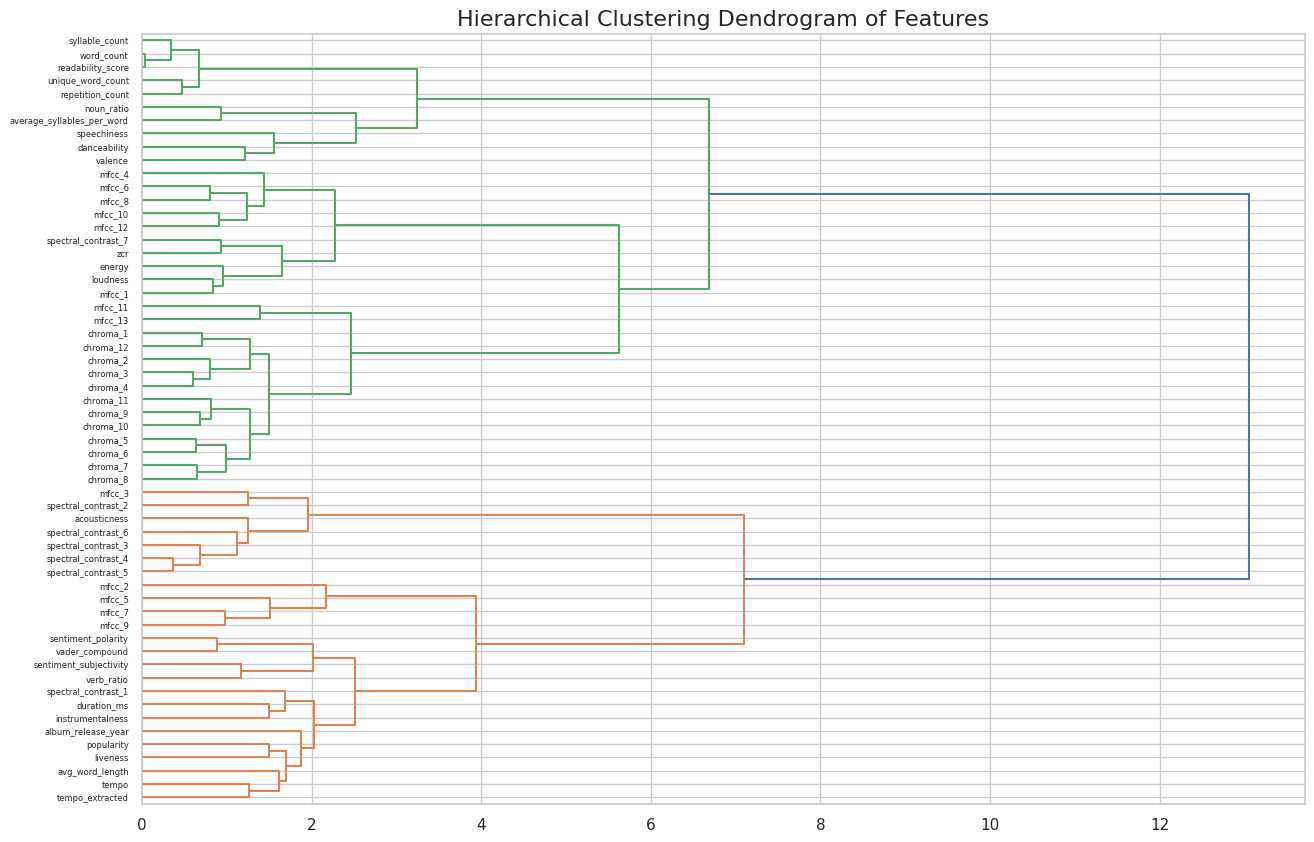

In [57]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

corr_matrix = num_df.corr()

linked = linkage(corr_matrix, 'ward')

plt.figure(figsize=(15, 10))
dendrogram(linked, labels=corr_matrix.columns, orientation='right', distance_sort='descending')
plt.title('Hierarchical Clustering Dendrogram of Features', fontsize=16)
plt.show()

## 3. Pairplot for Highly Correlated Features
Purpose:
The pairplot is used to visualize the relationships between pairs of highly correlated features, enabling you to see patterns or potential relationships.

How It Works:

After identifying features with a high correlation (above 0.7 in your case), the pairplot generates scatter plots for each pair of features.
It also shows the distribution of each feature along the diagonal of the plot.
This technique highlights relationships that might not be immediately obvious in raw numerical data.
Conclusion:
The pairplot allows you to confirm whether highly correlated features exhibit a strong linear relationship or if they follow a more complex pattern. For example, features like energy and loudness might show a positive linear relationship in the pairplot.

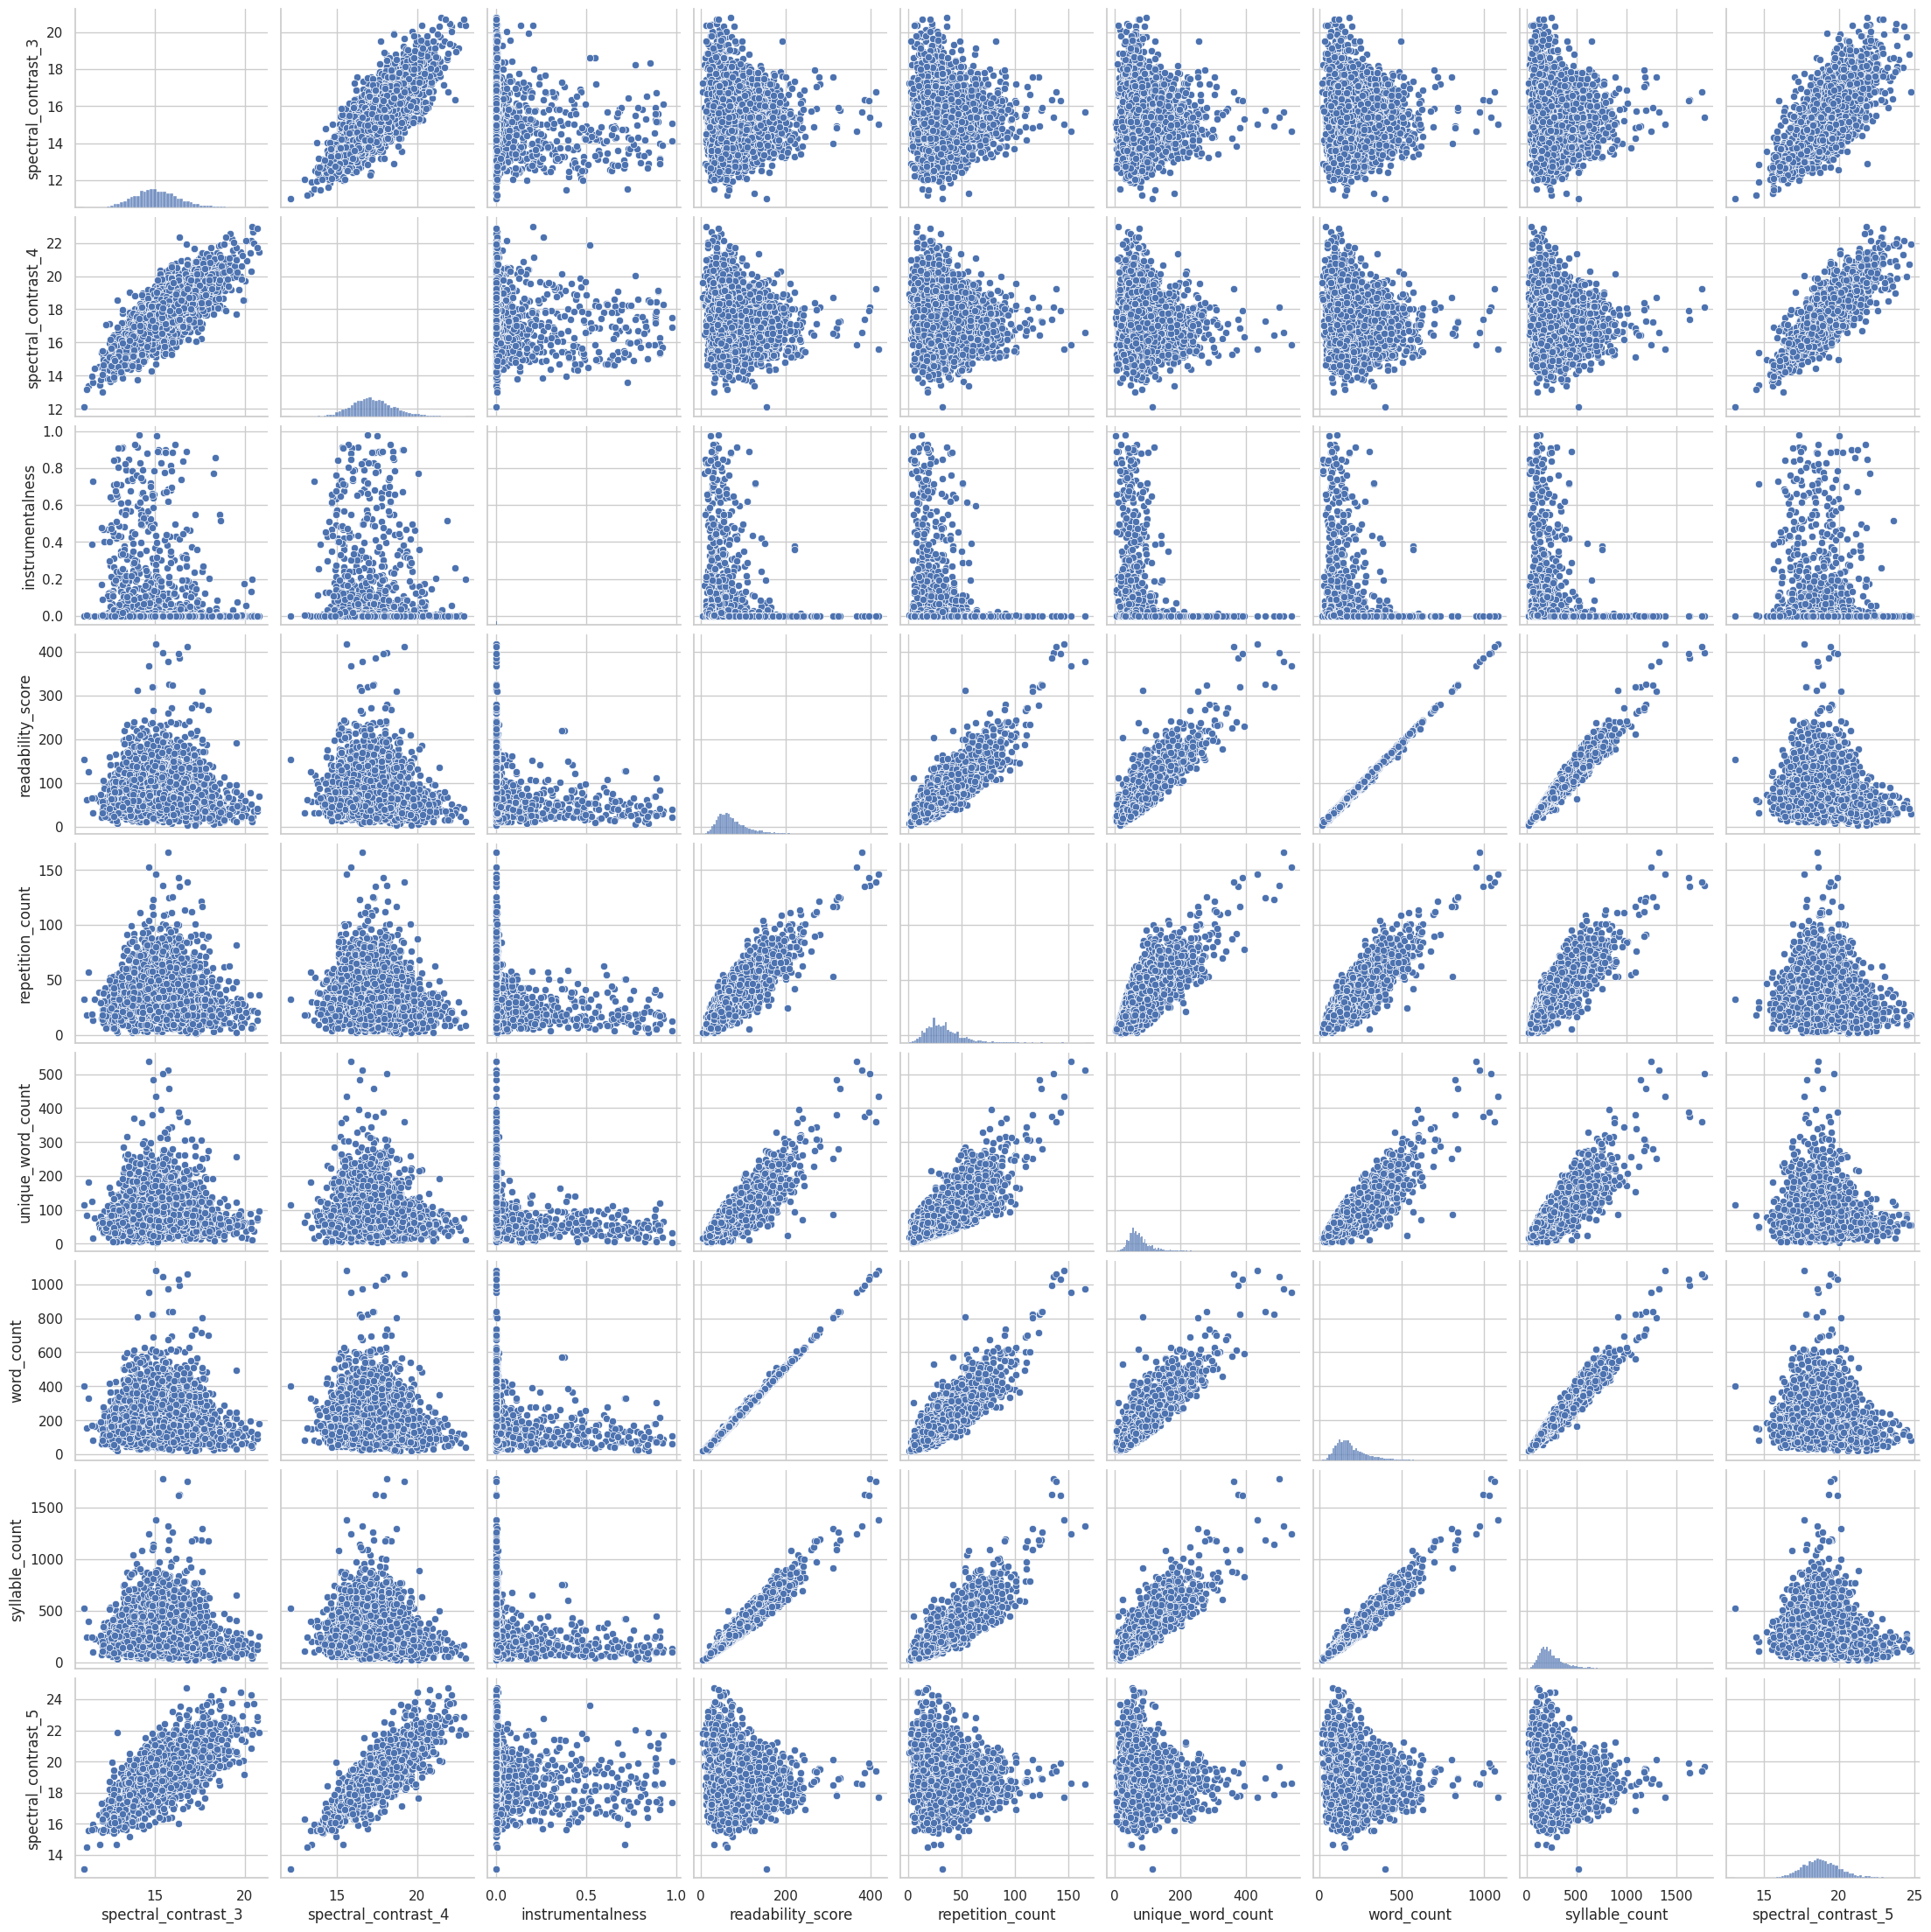

In [58]:
corr_matrix = num_df.corr().abs()
high_corr_var = corr_matrix.unstack().sort_values(kind="quicksort", ascending=False).drop_duplicates()
high_corr_var = high_corr_var[high_corr_var > 0.8]

top_corr_pairs = high_corr_var.index.tolist()
top_features = list(set([feature for pair in top_corr_pairs for feature in pair]))

sns.pairplot(num_df[top_features])
plt.show()

## 4. Network Graph of Highly Correlated Features
Purpose:
This method visualizes the relationships between highly correlated features as a network graph. It helps in understanding how features are interconnected.

How It Works:

You constructed a graph where each node represents a feature, and edges between nodes represent strong correlations (above a threshold, e.g., 0.7).
The spring layout was used to visualize the network, where highly connected nodes are pulled together, and less connected nodes are pushed apart.
Conclusion:
The network graph gives a visual summary of how features relate to each other, with clusters of nodes indicating groups of correlated features. This helps identify which features tend to co-occur in specific types of songs, such as danceability and energy forming one group, and acousticness and instrumentalness forming another.

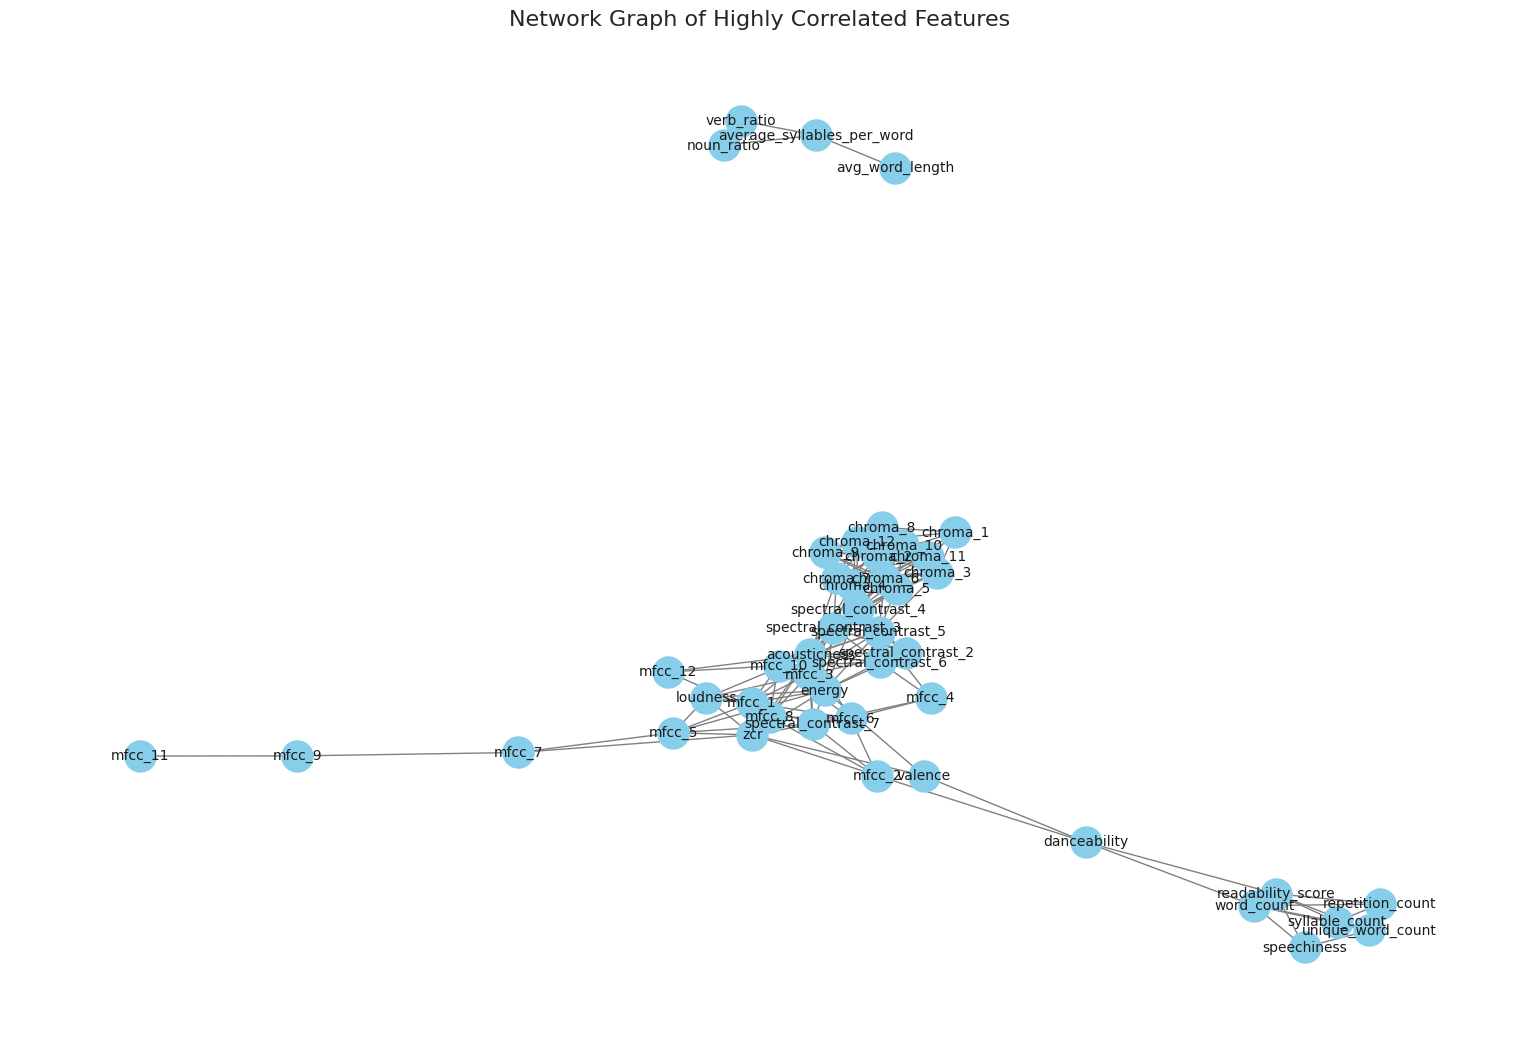

In [61]:
import networkx as nx

corr_matrix = num_df.corr().abs()
high_corr_pairs = corr_matrix.unstack().reset_index()
high_corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
high_corr_pairs = high_corr_pairs[(high_corr_pairs['Correlation'] > 0.4) & (high_corr_pairs['Feature1'] != high_corr_pairs['Feature2'])]

G = nx.from_pandas_edgelist(high_corr_pairs, 'Feature1', 'Feature2', edge_attr='Correlation')

plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, k=0.15)
nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', edge_color='gray', font_size=10)
plt.title('Network Graph of Highly Correlated Features', fontsize=16)
plt.show()


## 5. t-SNE (t-Distributed Stochastic Neighbor Embedding)
Purpose:
t-SNE is used to visualize high-dimensional data in a 2D or 3D space while preserving local structure (similarities between points). It is particularly useful for visualizing clusters in data.

How It Works:

t-SNE reduces the dimensionality of data by modeling pairwise similarities between points in high-dimensional space and attempts to preserve these similarities in the low-dimensional projection.
t-SNE uses a probability distribution to calculate the similarity between points, with closer points in the original space being more likely to remain close in the reduced space.
It is useful for visualizing non-linear relationships in data, unlike PCA, which focuses on linear variance.
Conclusion:
In your t-SNE plot, you likely saw clusters of points corresponding to groups of songs that are similar in terms of their features. Well-separated clusters suggest that the songs in different groups are quite distinct in terms of musical characteristics or lyrics.



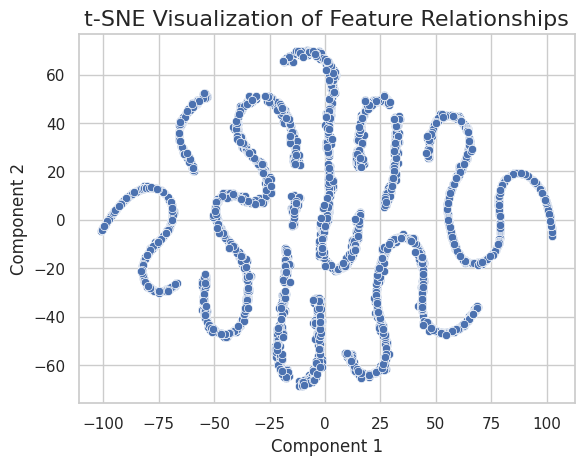

In [62]:
from sklearn.manifold import TSNE
import seaborn as sns

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(num_df)

tsne_df = pd.DataFrame(tsne_result, columns=['Component 1', 'Component 2'])
sns.scatterplot(x='Component 1', y='Component 2', data=tsne_df)
plt.title('t-SNE Visualization of Feature Relationships', fontsize=16)
plt.show()

# Mean song popualrity per genre

<Axes: xlabel='popularity', ylabel='Count'>

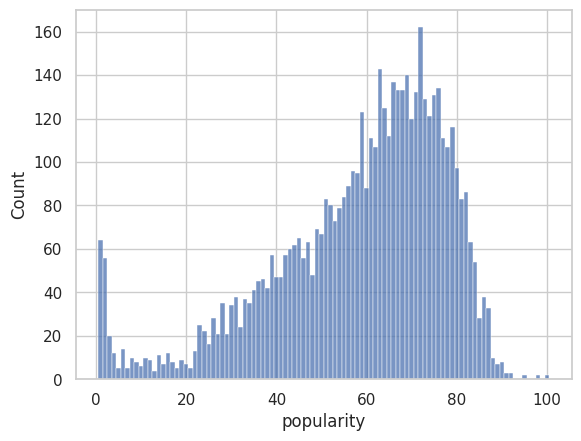

In [67]:
sns.histplot(df[df.popularity_imputed == 0].popularity, discrete=True)

<Axes: xlabel='genre'>

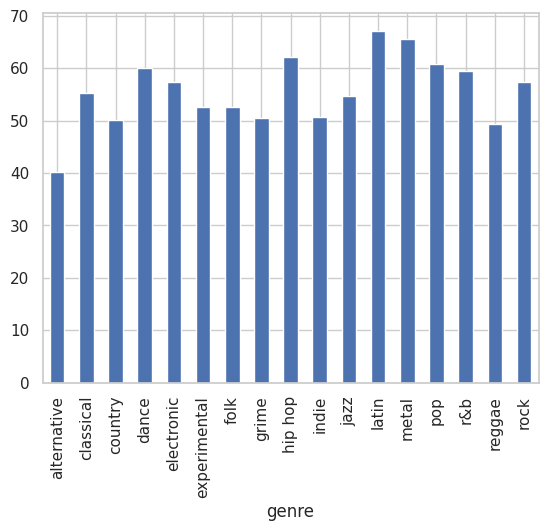

In [70]:
df.groupby("genre").popularity.mean().plot(kind='bar')

# Percent of explicit songs per year

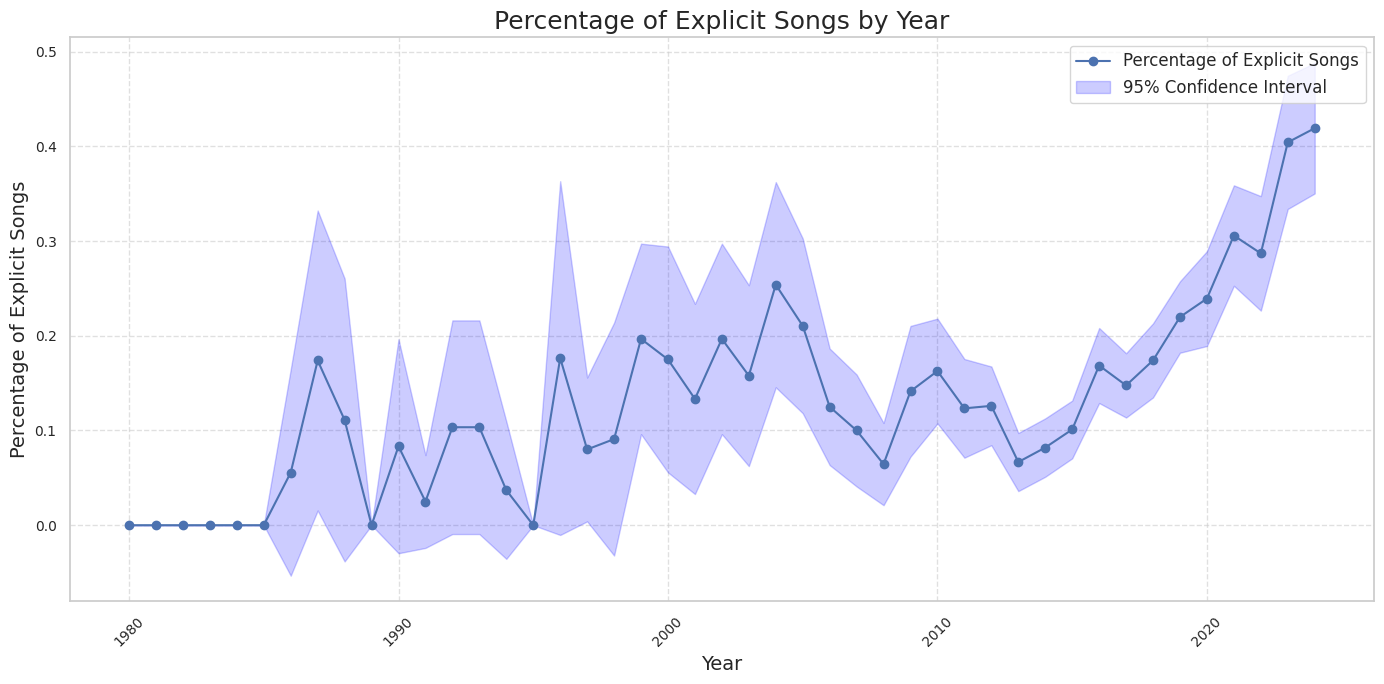

In [177]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure that tmp.explicit is numeric (0 or 1)
tmp = df[['explicit', 'album_release_year']].copy()
tmp['explicit_int'] = tmp['explicit'].astype(int)

# Group data by year and calculate the mean, sample size, and standard deviation
summary = (
    tmp.groupby('album_release_year')['explicit_int']
    .agg(['mean', 'count', 'std'])
    .reset_index()
    .rename(columns={'mean': 'percentage_explicit', 'count': 'sample_size', 'std': 'std_dev'})
)

# Calculate confidence intervals (assuming a normal distribution)
summary['ci'] = 1.96 * (summary['std_dev'] / np.sqrt(summary['sample_size']))

# Filter years to start from 1980
summary = summary[summary['album_release_year'] >= 1980]

# Plotting the lineplot with confidence intervals
plt.figure(figsize=(14, 7))
plt.plot(
    summary['album_release_year'], 
    summary['percentage_explicit'], 
    marker='o', 
    label='Percentage of Explicit Songs'
)

# Add shaded confidence intervals
plt.fill_between(
    summary['album_release_year'], 
    summary['percentage_explicit'] - summary['ci'], 
    summary['percentage_explicit'] + summary['ci'], 
    color='blue', 
    alpha=0.2, 
    label='95% Confidence Interval'
)

# Add titles and labels
plt.title('Percentage of Explicit Songs by Year', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Percentage of Explicit Songs', fontsize=14)

# Customize ticks and grid
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(visible=True, linestyle='--', alpha=0.6)

# Add legend
plt.legend(fontsize=12)

# Improve layout
plt.tight_layout()
plt.show()

# Popularity vs. explicit content

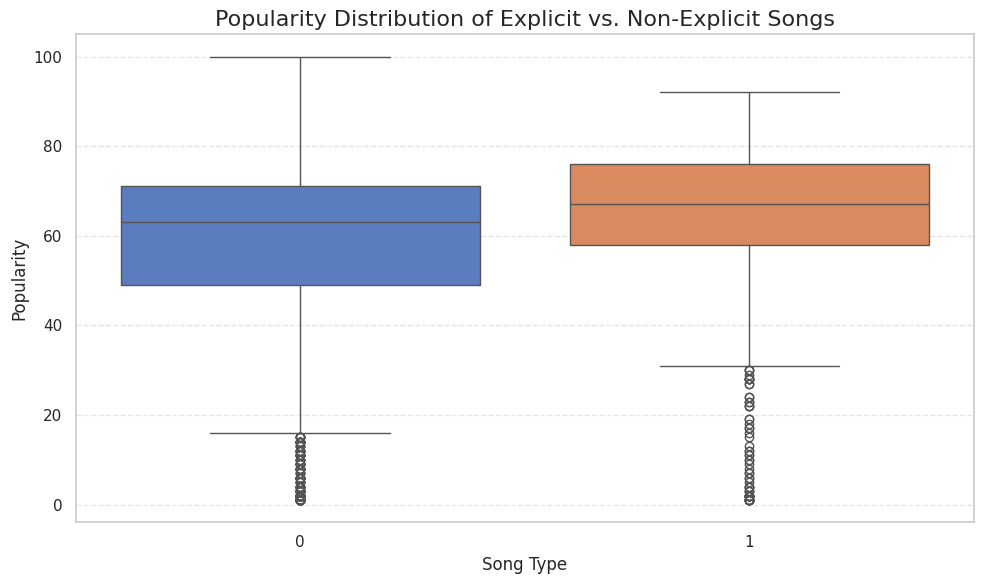

In [188]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


explicit_vs_popularity = tmp_df[['explicit', 'popularity']].copy()
explicit_vs_popularity['explicit_label'] = explicit_vs_popularity['explicit']

plt.figure(figsize=(10, 6))
sns.boxplot(
    x='explicit_label', 
    y='popularity', 
    data=explicit_vs_popularity, 
    palette='muted'
)

plt.title('Popularity Distribution of Explicit vs. Non-Explicit Songs', fontsize=16)
plt.xlabel('Song Type', fontsize=12)
plt.ylabel('Popularity', fontsize=12)

plt.tight_layout()
plt.grid(visible=True, linestyle='--', alpha=0.5, axis='y')
plt.show()

In [189]:
from scipy.stats import ttest_ind, mannwhitneyu
import numpy as np

def winsorize_series(series, lower_percentile=0.025, upper_percentile=0.975):
    lower_limit = np.percentile(series, lower_percentile * 100)
    upper_limit = np.percentile(series, upper_percentile * 100)
    return np.clip(series, lower_limit, upper_limit)

tmp_df['popularity_winsorized'] = winsorize_series(tmp_df['popularity'])

explicit_popularity = tmp_df.loc[tmp_df['explicit'] == '1', 'popularity_winsorized']
non_explicit_popularity = tmp_df.loc[tmp_df['explicit'] == '0', 'popularity_winsorized']

t_stat, t_pval = ttest_ind(explicit_popularity, non_explicit_popularity, equal_var=False)

u_stat, u_pval = mannwhitneyu(explicit_popularity, non_explicit_popularity, alternative='two-sided')

print(f"T-Test Results: t-statistic = {t_stat:.3f}, p-value = {t_pval:.3e}")
print(f"Mann-Whitney U Test Results: U-statistic = {u_stat:.3f}, p-value = {u_pval:.3e}")

T-Test Results: t-statistic = 8.482, p-value = 5.596e-17
Mann-Whitney U Test Results: U-statistic = 2891255.500, p-value = 1.198e-25


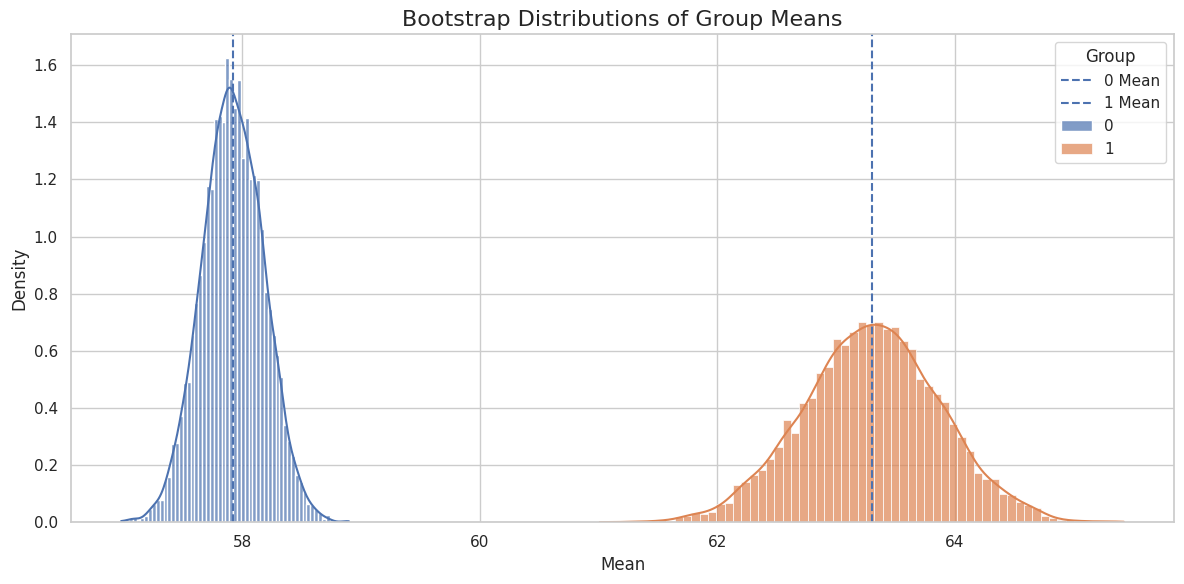

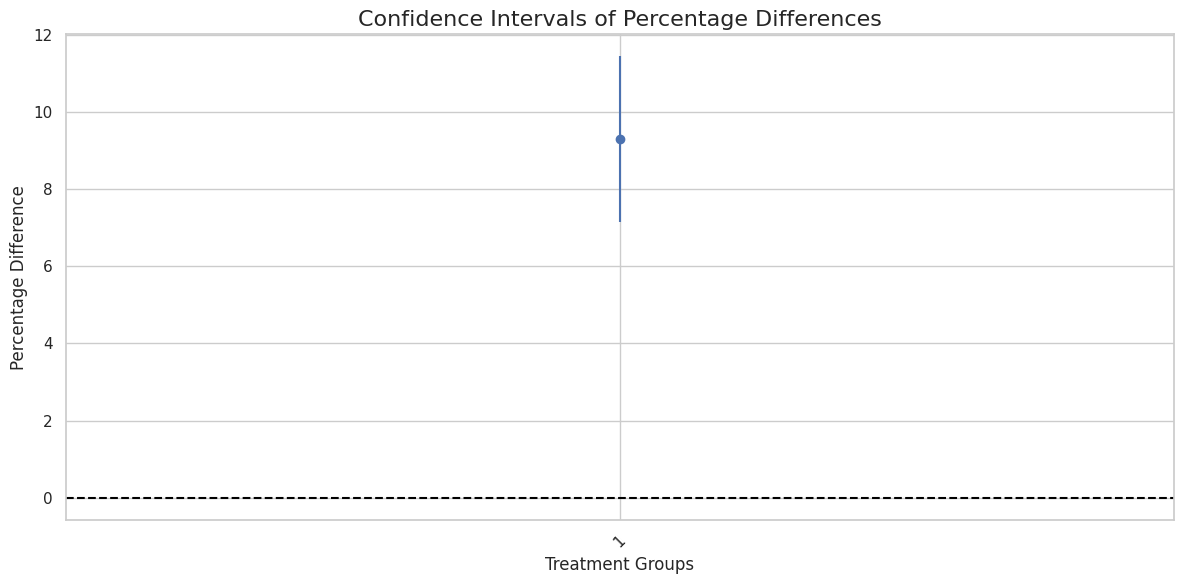

In [192]:
evaluator = BootstrapEvaluator(tmp_df, group_col="explicit", value_col="popularity_winsorized", control_group="0")
results = evaluator.evaluate(n_resamples=10000)
evaluator.plot_means_distribution()
evaluator.plot_interval()
evaluator.get_results_table()

In [185]:
genre_features = df.groupby("genre")[spotify_features + audio_extracted_features + lyrics_features].mean()

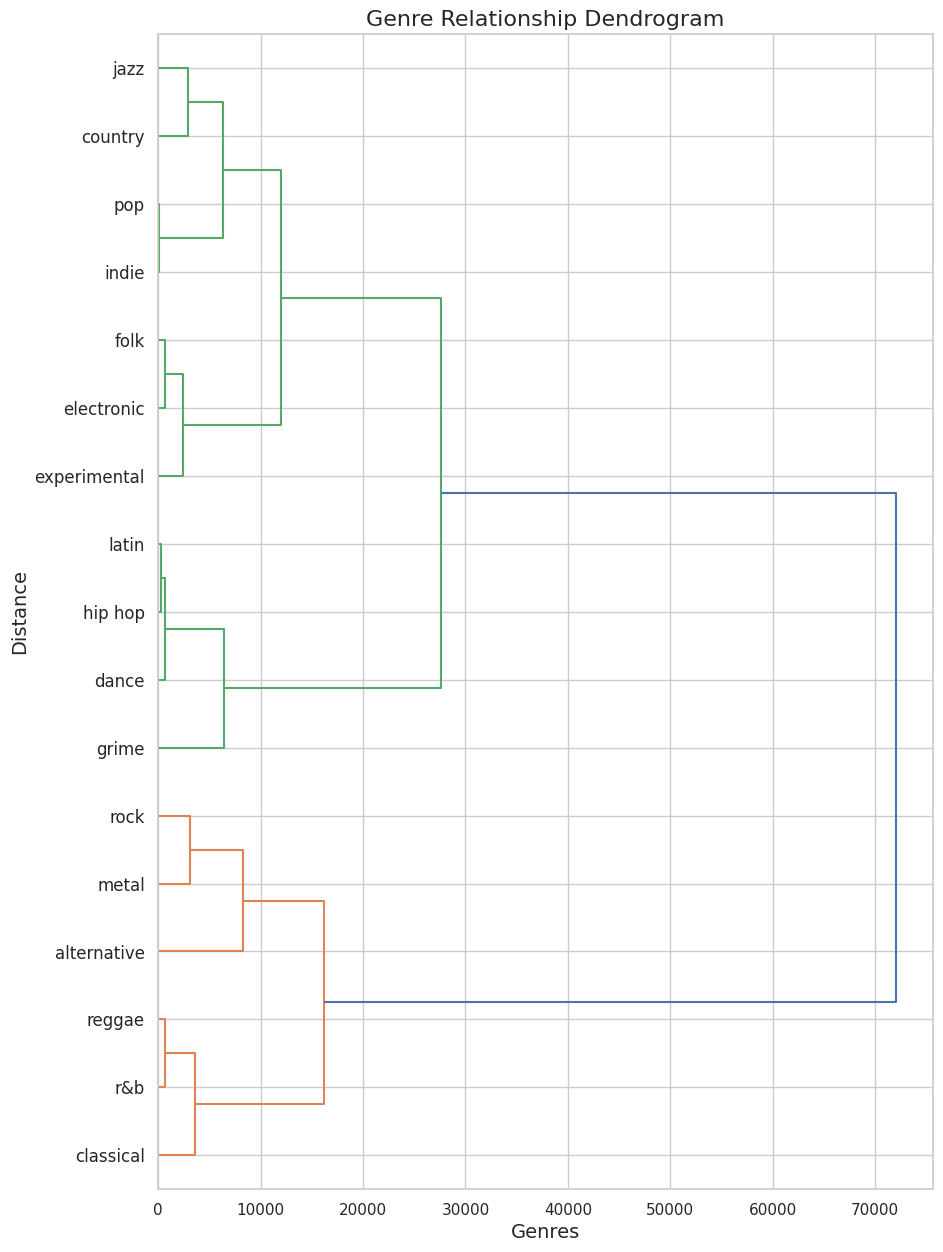

In [196]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Perform hierarchical clustering
linkage_matrix = linkage(genre_features, method='ward')

# Create a wider plot
plt.figure(figsize=(10, 15))  # Adjust width and height
dendrogram(linkage_matrix, labels=genre_features.index,orientation='right')
plt.title("Genre Relationship Dendrogram", fontsize=16)
plt.xlabel("Genres", fontsize=14)
plt.ylabel("Distance", fontsize=14)
plt.show()


<Axes: >

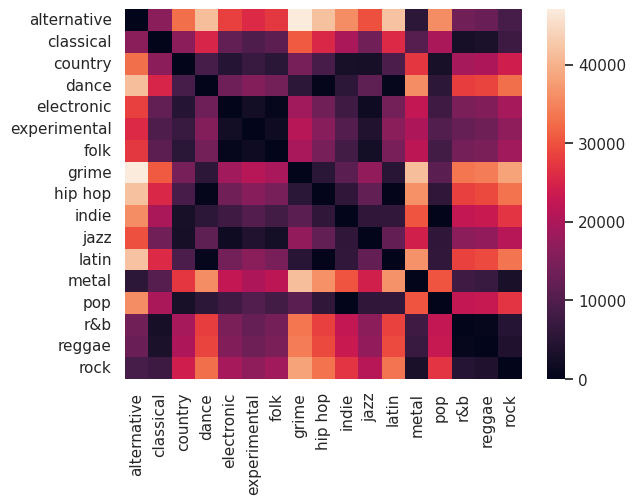

In [197]:
from scipy.spatial.distance import pdist, squareform
distance_matrix = squareform(pdist(genre_features, metric='euclidean'))
sns.heatmap(distance_matrix, xticklabels=genre_features.index, yticklabels=genre_features.index)#, cmap="viridis")

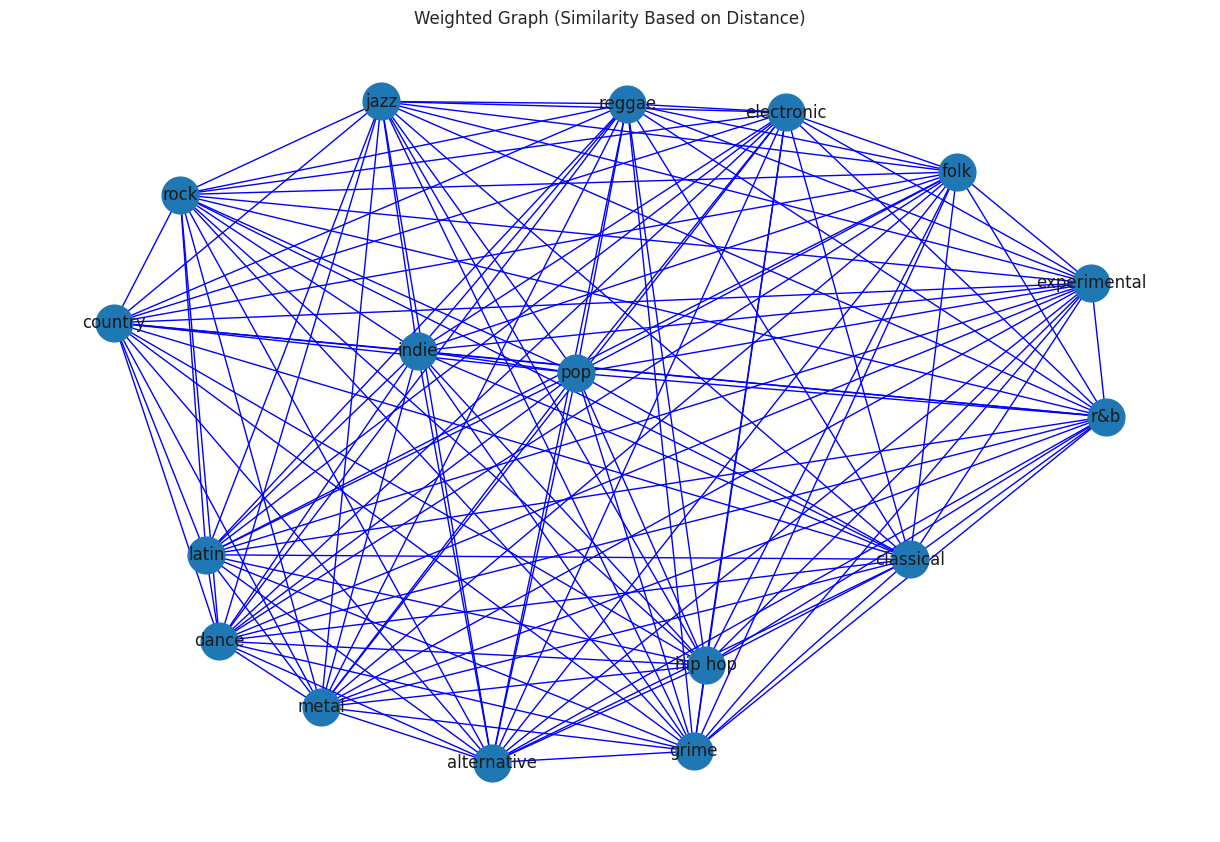

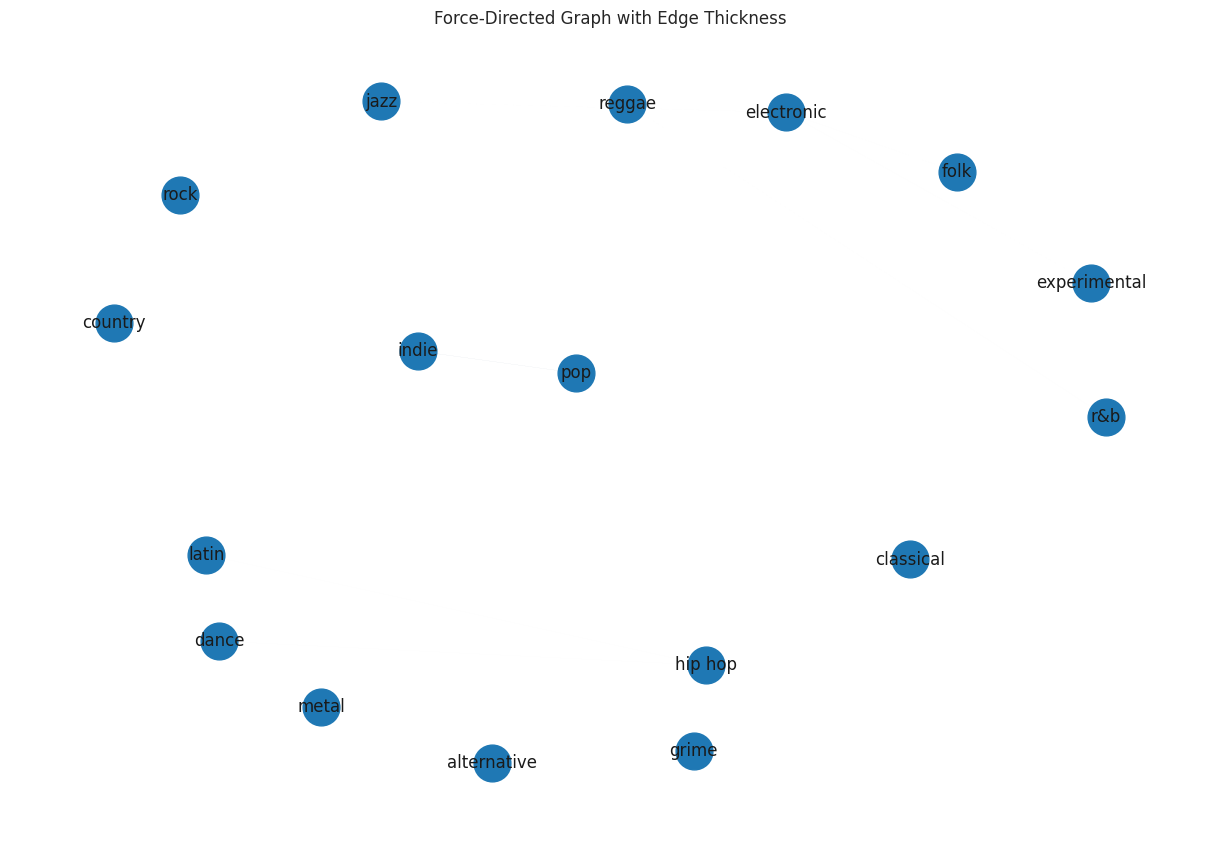

In [41]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import numpy as np

# 2. Compute the Distance Matrix
distance_matrix = squareform(pdist(genre_features, metric='euclidean'))
genres = genre_features.index.tolist()

# Mapping node indices to genres
node_mapping = {i: genres[i] for i in range(len(genres))}

# 3. Weighted Graph
plt.figure(figsize=(12, 8))
G_weighted = nx.Graph()

# Add edges and nodes based on distances
for i in range(len(distance_matrix)):
    for j in range(i + 1, len(distance_matrix)):
        similarity = 1 / (distance_matrix[i, j] + 1e-5)  # Avoid division by zero
        G_weighted.add_edge(i, j, weight=similarity)

pos_weighted = nx.spring_layout(G_weighted, weight='weight')
nx.draw(G_weighted, pos_weighted, with_labels=True, labels=node_mapping,
        node_size=700, font_size=12, edge_color='blue')
plt.title("Weighted Graph (Similarity Based on Distance)")
plt.show()


# 5. Force-Directed Layout with Edge Thickness
plt.figure(figsize=(12, 8))
edges = G_weighted.edges(data=True)
edge_weights = [d['weight'] for (_, _, d) in edges]  # Extract edge weights
nx.draw(G_weighted, pos_weighted, with_labels=True, labels=node_mapping,
        node_size=700, font_size=12, width=edge_weights, edge_color=edge_weights, edge_cmap=plt.cm.Blues)
plt.title("Force-Directed Graph with Edge Thickness")
plt.show()


# Test Lyrical Complexity and Popularity
Hypothesis: Songs with simpler lyrics are more likely to be popular.

In [8]:
lyrical_complexity_features = [
    'lexical_richness',
    'semantic_depth',
    'syntactic_complexity',
    'rhyme_density',
    'sentiment_variability',
    'linguistic_uniqueness',
    'flesch_reading_ease',
    'gunning_fog',
    'dale_chall',
    'type_token_ratio'
]

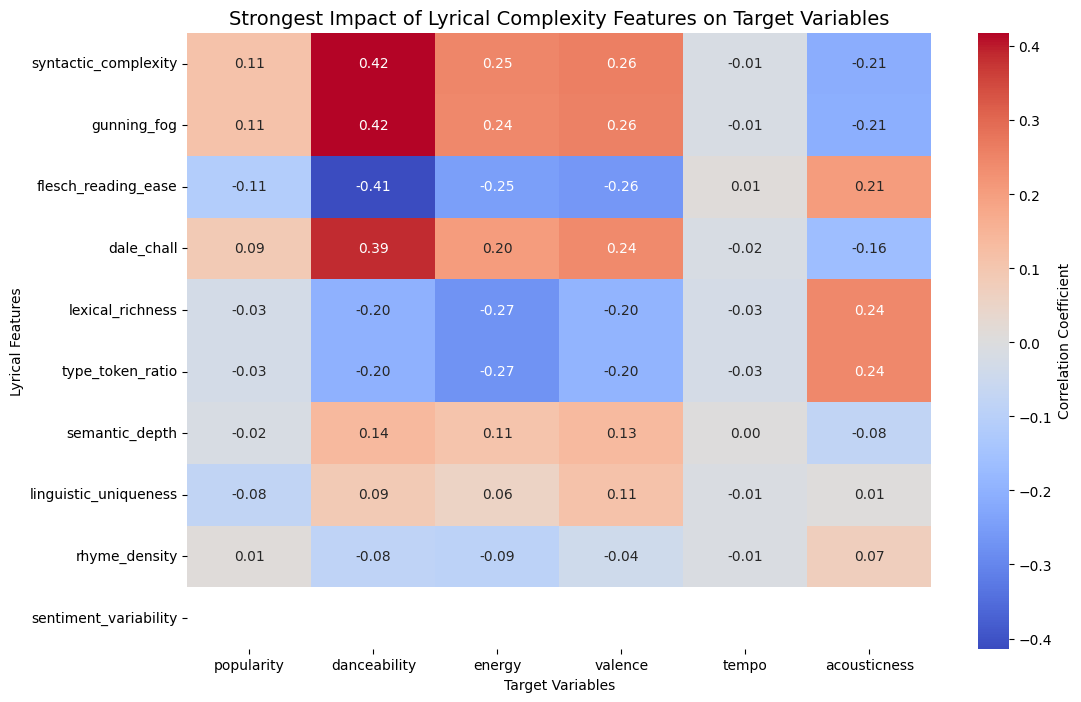

In [14]:
# Select features and targets
lyrical_features = [
    'lexical_richness',
    'semantic_depth',
    'syntactic_complexity',
    'rhyme_density',
    'sentiment_variability',
    'linguistic_uniqueness',
    'flesch_reading_ease',
    'gunning_fog',
    'dale_chall',
    'type_token_ratio'
]
targets = ['popularity', 'danceability', 'energy', 'valence', 'tempo', 'acousticness']

# Filter numerical columns and drop NaN values
num_df = df[lyrical_features + targets].dropna().select_dtypes(include=[np.number])

# Compute correlation matrix
corr_matrix = num_df.corr()

# Extract correlations between lyrical features and target variables
lyrical_target_corr = corr_matrix.loc[lyrical_features, targets]

# Identify the strongest correlations for each lyrical feature
strongest_impact = lyrical_target_corr.abs().max(axis=1).sort_values(ascending=False)
strongest_features = strongest_impact.index

# Filter and visualize the strongest relationships
plt.figure(figsize=(12, 8))
sns.heatmap(
    lyrical_target_corr.loc[strongest_features, :], 
    annot=True, 
    cmap='coolwarm', 
    fmt='.2f', 
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title('Strongest Impact of Lyrical Complexity Features on Target Variables', fontsize=14)
plt.ylabel('Lyrical Features')
plt.xlabel('Target Variables')
plt.show()


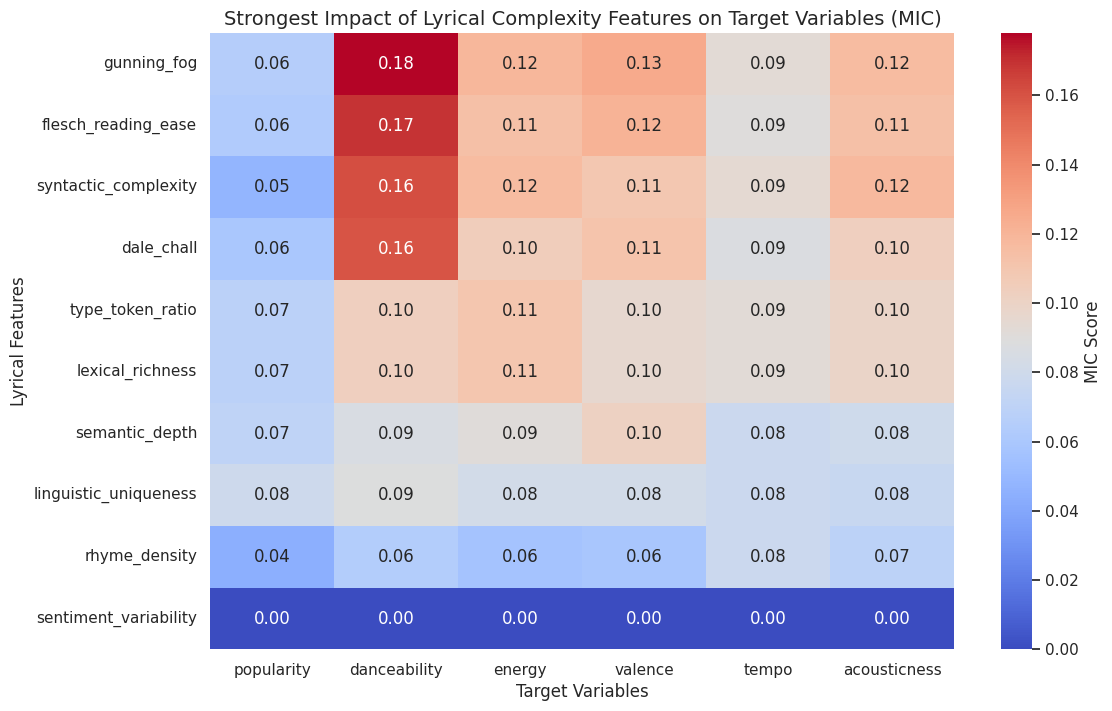

In [341]:
from minepy import MINE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Select features and targets
lyrical_features = [
    'lexical_richness',
    'semantic_depth',
    'syntactic_complexity',
    'rhyme_density',
    'sentiment_variability',
    'linguistic_uniqueness',
    'flesch_reading_ease',
    'gunning_fog',
    'dale_chall',
    'type_token_ratio'
]
targets = ['popularity', 'danceability', 'energy', 'valence', 'tempo', 'acousticness']

# Filter numerical columns and drop NaN values
num_df = df[lyrical_features + targets].dropna().select_dtypes(include=[np.number])

# Function to compute MIC
def compute_mic(X, Y):
    """Computes MIC between two pandas Series."""
    mine = MINE()
    mine.compute_score(X, Y)
    return mine.mic()

# Compute MIC for each lyrical feature against each target
mic_values = []
for lyrical_feature in lyrical_features:
    row = []
    for target in targets:
        mic_score = compute_mic(num_df[lyrical_feature], num_df[target])
        row.append(mic_score)
    mic_values.append(row)

# Create a DataFrame for MIC results
mic_df = pd.DataFrame(mic_values, index=lyrical_features, columns=targets)

# Identify the strongest MIC scores
strongest_impact = mic_df.max(axis=1).sort_values(ascending=False)
strongest_features = strongest_impact.index

# Filter and visualize the strongest relationships
plt.figure(figsize=(12, 8))
sns.heatmap(
    mic_df.loc[strongest_features, :], 
    annot=True, 
    cmap='coolwarm', 
    fmt='.2f', 
    cbar_kws={'label': 'MIC Score'}
)
plt.title('Strongest Impact of Lyrical Complexity Features on Target Variables (MIC)', fontsize=14)
plt.ylabel('Lyrical Features')
plt.xlabel('Target Variables')
plt.show()


In [342]:
import statsmodels.api as sm

def regression_significance(df, features, target):
    results = {}
    for feature in features:
        X = sm.add_constant(df[feature])  # Add constant for intercept
        y = df[target]
        model = sm.OLS(y, X).fit()
        results[feature] = {
            "p_value": model.pvalues[1],  # P-value for the feature
            "coef": model.params[1],  # Coefficient
            "r_squared": model.rsquared,  # R-squared
        }
    return pd.DataFrame(results).T.sort_values("p_value")

# Example usage
significance_df = regression_significance(df, lyrical_features, "popularity")
significance_df

p_value       coef     r_squared
flesch_reading_ease    1.205033e-16  -0.018771  1.265976e-02
gunning_fog            1.425091e-16   0.048223  1.259911e-02
syntactic_complexity   2.836180e-16   0.018861  1.235025e-02
dale_chall             1.685304e-10   0.269582  7.548889e-03
linguistic_uniqueness  1.447047e-08  -8.645167  5.948090e-03
lexical_richness       3.830229e-02  -3.962914  7.967012e-04
type_token_ratio       3.830229e-02  -3.962914  7.967012e-04
semantic_depth         2.194541e-01  -0.409503  2.800122e-04
rhyme_density          3.939745e-01  30.649240  1.349412e-04
sentiment_variability           NaN   0.000000  3.330669e-16

These results imply that while lyrical features contribute to the target variables, other factors (e.g., production quality, artist popularity, cultural trends) likely play a far more significant role.

In [277]:
target = 'danceability'
reg_pipeline = OptimalRegressionPipeline(
    df.dropna(subset=[target]),
    target_column=target,
    num_features=lyrical_complexity_features,
    cat_features=[],
    n_trials=10,
    param_grid={
        "iterations": [500, 1000],
        "depth": [4, 6, 8],
        "learning_rate": (0.01, 0.1),
        "l2_leaf_reg": (1, 10),
    },
    cache_path="catboost_optuna.db"
)
reg_pipeline.get_pipeline()

INFO: Initializing pipeline for target variable: danceability
INFO: Setting up the pipeline...
INFO: Setting up the pipeline...


TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        transformers=[('num',
                                                                                       Pipeline(steps=[('imputer',
                                                                                                        SimpleImputer()),
                                                                                                       ('scaler',
                                                                                                        StandardScaler())]),
                                                                                       ['lexical_richness',
                                                                                        'semantic_depth',
                                                                                        'syntactic_complexity',
                                                                                        'rhyme_density',
                                                                                        'sentiment_variability',
                                                                                        'linguistic_uniqueness',
                                                                                        'flesch_reading_ease',
                                                                                        'gunning_fog',
                                                                                        'dale_chall',
                                                                                        'type_token_ratio']),
                                                                                      ('cat',
                                                                                       Pipeline(steps=[('imputer',
                                                                                                        SimpleImputer(fill_value='unknown',
                                                                                                                      strategy='constant'))]),
                                                                                       [])],
                                                                        verbose_feature_names_out=False)),
                                                     ('model',
                                                      <classes.optimal_catboost.OptimalCatBoostRegressor object at 0x7a32fc292b60>)]),
                           transformer=Pipeline(steps=[('scaler',
                                                        StandardScaler())]))

In [278]:
reg_pipeline.split()
reg_pipeline.train_model()

INFO: Splitting the data into training and testing sets...
INFO: Data splitting completed.
INFO: Training the OptimalCatBoostRegressor through the pipeline...


[I 2024-12-14 00:21:49,349] A new study created in RDB with name: catboost_optimization_4409a170-3dea-46df-bfac-bda45279e949
[I 2024-12-14 00:22:23,619] Trial 1 finished with value: -0.7855098881726492 and parameters: {'iterations': 1000, 'depth': 6, 'learning_rate': 0.06695248653071907, 'l2_leaf_reg': 7.849122254418068}. Best is trial 1 with value: -0.7855098881726492.
[I 2024-12-14 00:22:24,940] Trial 4 finished with value: -0.7785724729918172 and parameters: {'iterations': 1000, 'depth': 6, 'learning_rate': 0.06445633788257696, 'l2_leaf_reg': 3.1836620188924094}. Best is trial 4 with value: -0.7785724729918172.
[I 2024-12-14 00:22:26,079] Trial 6 finished with value: -0.7839694958311728 and parameters: {'iterations': 1000, 'depth': 6, 'learning_rate': 0.06462409737849606, 'l2_leaf_reg': 4.688520250684409}. Best is trial 4 with value: -0.7785724729918172.
[I 2024-12-14 00:22:26,480] Trial 5 finished with value: -0.7810099266370989 and parameters: {'iterations': 1000, 'depth': 6, 'lea

INFO: Pipeline training completed.


In [279]:
reg_pipeline.model.training_results

Metric  Score
0    MAE  0.687
1    MSE  0.773
2   RMSE  0.879
3     R2  0.226

INFO: Evaluating the regression model...


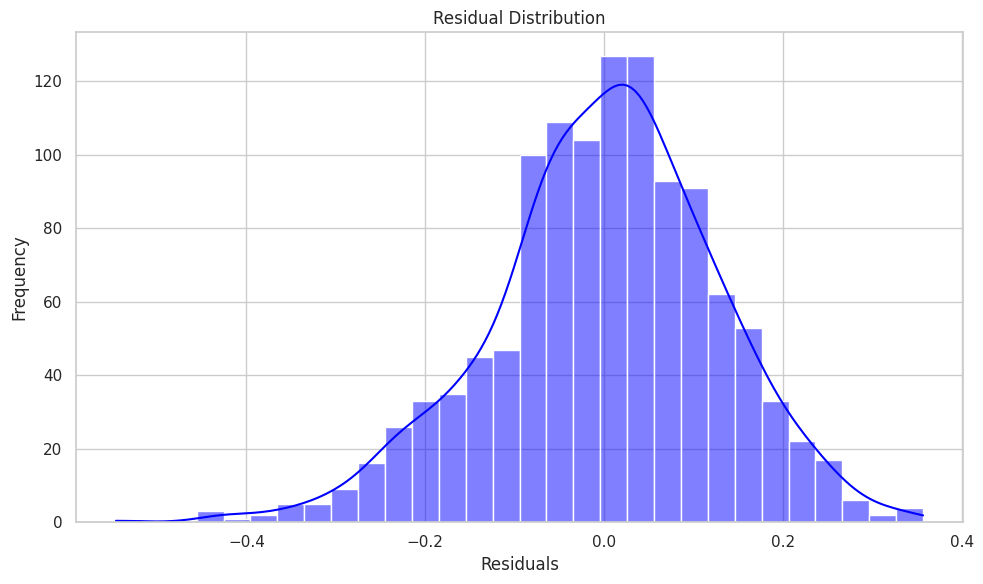

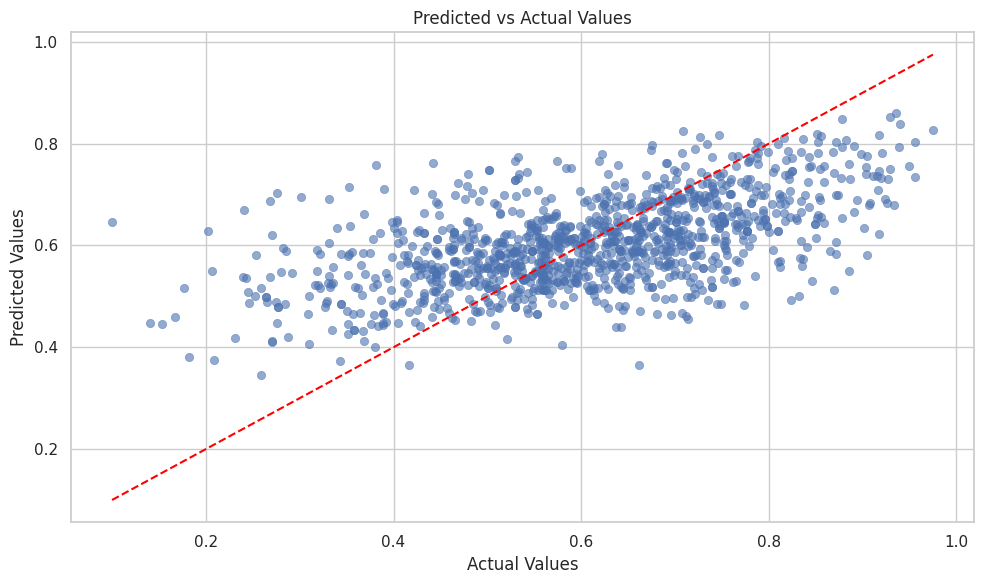

Metric     Score
0      Mean Absolute Error  0.098720
1       Mean Squared Error  0.016086
2  Root Mean Squared Error  0.126832
3                 R2 Score  0.316676

In [280]:
reg_pipeline.evaluate_model()

INFO: Performing SHAP analysis...
INFO: Binary classification or regression detected.


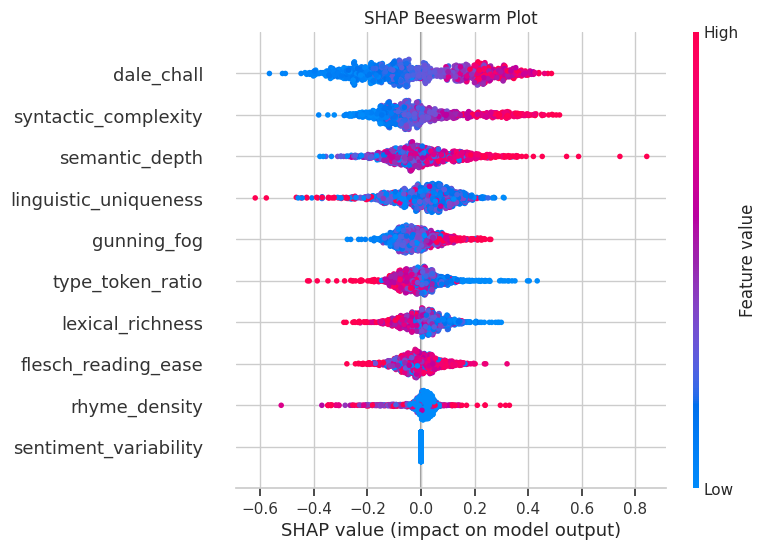

INFO: Generating feature importance bar plot...


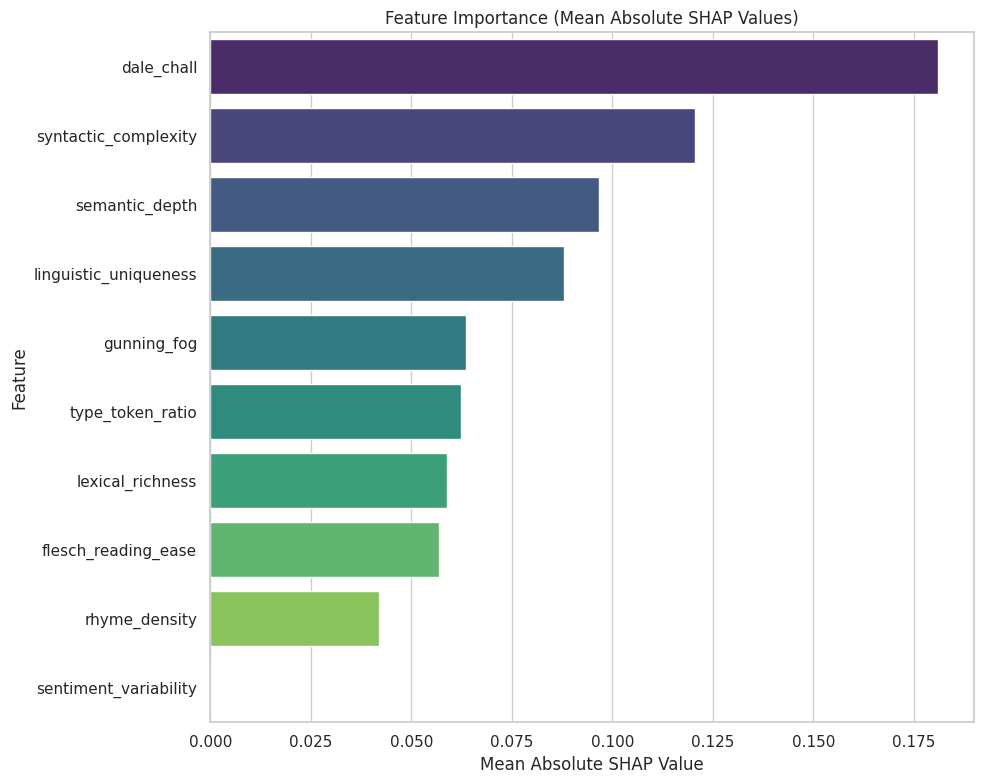

In [281]:
reg_pipeline.perform_shap_analysis()

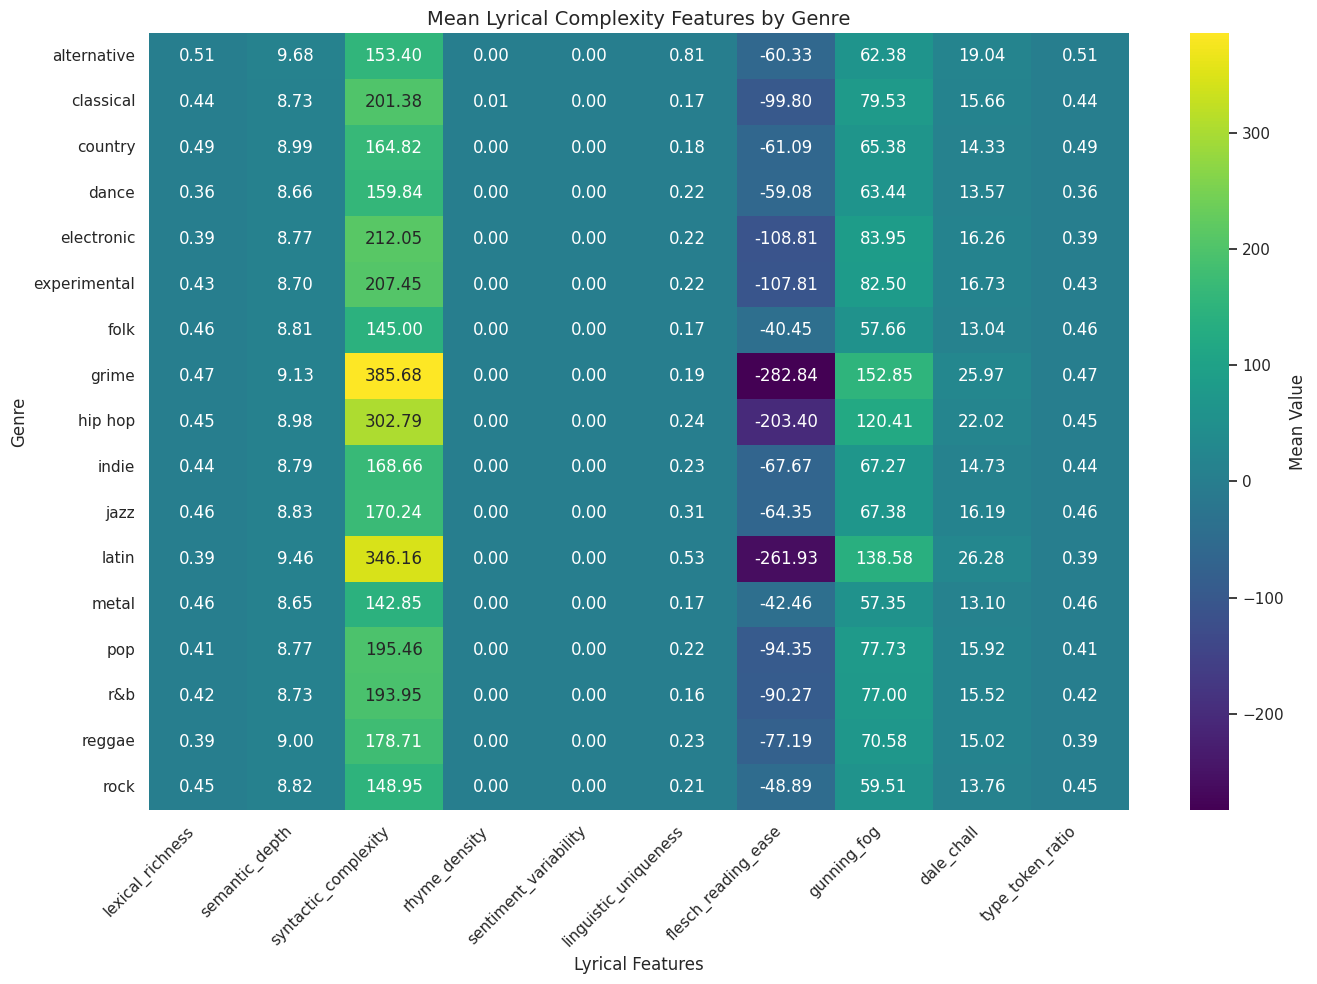

In [282]:
# Calculate mean values of lyrical features for each genre
genre_means = df.groupby('genre')[lyrical_features].mean()

# Heatmap of mean lyrical feature values by genre
plt.figure(figsize=(14, 10))
sns.heatmap(genre_means, annot=True, cmap='viridis', fmt='.2f', cbar_kws={'label': 'Mean Value'})
plt.title('Mean Lyrical Complexity Features by Genre', fontsize=14)
plt.xlabel('Lyrical Features', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Sentiment and Genre: Sentiment polarity and subjectivity vary significantly across genres.

Hypothesis: Sentiment polarity and subjectivity vary significantly across genres.
Use clustering and sentiment analysis to group genres by sentiment characteristics.

# Temporal Trends in Features:

Hypothesis: Newer songs (recent album release years) tend to have shorter durations and simpler structures (lower syllable count, fewer unique words).
Perform a temporal analysis to verify how features evolve over time.

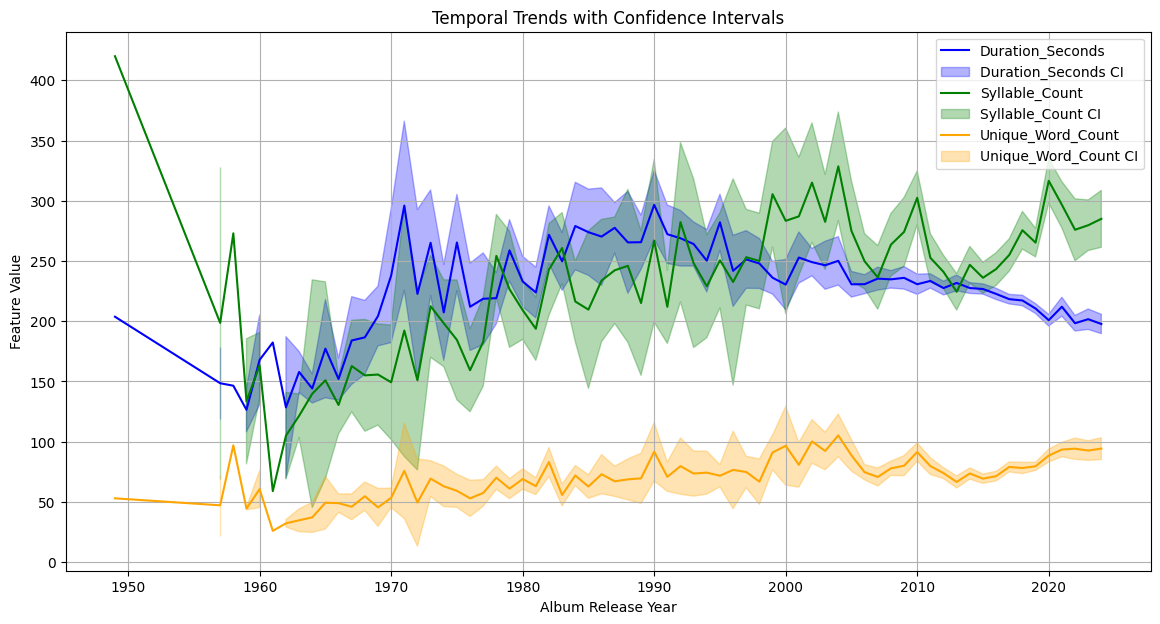

In [48]:
import numpy as np

# Group data by year and compute mean, std, and count
agg_data = df.groupby('album_release_year').agg({
    'duration_seconds': ['mean', 'std', 'count'],
    'syllable_count': ['mean', 'std', 'count'],
    'unique_word_count': ['mean', 'std', 'count']
})

# Flatten multi-level columns
agg_data.columns = ['_'.join(col) for col in agg_data.columns]

# Compute 95% confidence intervals
for feature in ['duration_seconds', 'syllable_count', 'unique_word_count']:
    mean_col = f"{feature}_mean"
    std_col = f"{feature}_std"
    count_col = f"{feature}_count"
    agg_data[f"{feature}_ci_lower"] = agg_data[mean_col] - 1.96 * (agg_data[std_col] / np.sqrt(agg_data[count_col]))
    agg_data[f"{feature}_ci_upper"] = agg_data[mean_col] + 1.96 * (agg_data[std_col] / np.sqrt(agg_data[count_col]))

# Plot temporal trends with manual confidence intervals
plt.figure(figsize=(14, 7))
for feature, color in zip(['duration_seconds', 'syllable_count', 'unique_word_count'], ['blue', 'green', 'orange']):
    plt.plot(agg_data.index, agg_data[f"{feature}_mean"], label=f"{feature.title()}", color=color)
    plt.fill_between(
        agg_data.index, 
        agg_data[f"{feature}_ci_lower"], 
        agg_data[f"{feature}_ci_upper"], 
        color=color, alpha=0.3, label=f"{feature.title()} CI"
    )
plt.title("Temporal Trends with Confidence Intervals")
plt.xlabel("Album Release Year")
plt.ylabel("Feature Value")
plt.legend()
plt.grid()
plt.show()


In [45]:
from scipy.stats import linregress

# Perform linear regression for each feature
features = ['duration_seconds', 'syllable_count', 'unique_word_count']
for feature in features:
    slope, intercept, r_value, p_value, std_err = linregress(temporal_trends['album_release_year'], temporal_trends[feature])
    print(f"{feature} vs. album_release_year:")
    print(f"  Slope = {slope:.3f}")
    print(f"  p-value = {p_value:.3e}")
    print(f"  R-squared = {r_value**2:.3f}\n")


duration_seconds vs. album_release_year:
  Slope = 0.672
  p-value = 4.029e-03
  R-squared = 0.117

syllable_count vs. album_release_year:
  Slope = 1.801
  p-value = 5.277e-08
  R-squared = 0.359

unique_word_count vs. album_release_year:
  Slope = 0.622
  p-value = 2.695e-12
  R-squared = 0.520



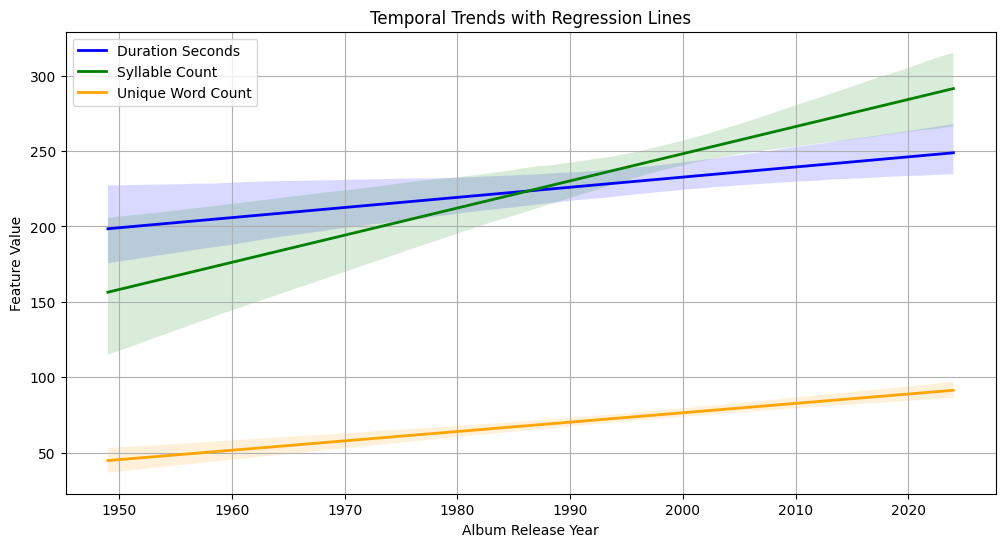

In [46]:
# Plot temporal trends with regression lines
plt.figure(figsize=(12, 6))
for feature, color in zip(['duration_seconds', 'syllable_count', 'unique_word_count'], ['blue', 'green', 'orange']):
    sns.regplot(
        data=temporal_trends, 
        x='album_release_year', 
        y=feature, 
        label=f"{feature.replace('_', ' ').title()}", 
        scatter=False, 
        color=color, 
        line_kws={'linewidth': 2}
    )
plt.title("Temporal Trends with Regression Lines")
plt.xlabel("Album Release Year")
plt.ylabel("Feature Value")
plt.legend()
plt.grid()
plt.show()


# Acoustic Features and Explicitness:

Hypothesis: Songs marked as explicit have distinct acoustic features such as higher energy or louder dynamics compared to non-explicit ones.
Use classification models to test the separability of explicit vs. non-explicit songs based on acoustic features.

In [247]:
num_acoustic_features = [
 'danceability',
 'energy',
 'loudness',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'mfcc_1',
 'mfcc_2',
 'mfcc_3',
 'mfcc_4',
 'mfcc_5',
 'mfcc_6',
 'mfcc_7',
 'mfcc_8',
 'mfcc_9',
 'mfcc_10',
 'mfcc_11',
 'mfcc_12',
 'mfcc_13',
 'chroma_1',
 'chroma_2',
 'chroma_3',
 'chroma_4',
 'chroma_5',
 'chroma_6',
 'chroma_7',
 'chroma_8',
 'chroma_9',
 'chroma_10',
 'chroma_11',
 'chroma_12',
 'spectral_contrast_1',
 'spectral_contrast_2',
 'spectral_contrast_3',
 'spectral_contrast_4',
 'spectral_contrast_5',
 'spectral_contrast_6',
 'spectral_contrast_7',
 'tempo_extracted',
 'zcr',
]
cat_acoustic_features = ['key', 'mode', 'time_signature']

# Optimal Classification

In [248]:
target = 'explicit'

In [249]:
cat_acoustic_features

['key', 'mode', 'time_signature']

In [250]:
clf_pipeline = OptimalClassificationPipeline(
    df.dropna(subset=[target]),
    target_column=target,
    num_features=num_acoustic_features,
    cat_features=cat_acoustic_features,
    n_trials=10,
    param_grid={
        "iterations": [500, 1000],
        "depth": [4, 6, 8],
        "learning_rate": (0.01, 0.1),
        "l2_leaf_reg": (1, 10),
    },
    cache_path="catboost_optuna.db"
)
clf_pipeline.get_pipeline()

INFO: Initializing pipeline for target variable: explicit
INFO: Setting up the pipeline...
INFO: Setting up the pipeline...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['danceability', 'energy',
                                                   'loudness', 'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'mfcc_1', 'mfcc_2',
                                                   'mfcc_3', 'mfcc_4', 'mfcc_5',
                                                   'mfcc_6', 'mfcc_7', 'mfcc...
                                                   'mfcc_13', 'chroma_1',
                                                   'chroma_2', 'chroma_3',
                                                   'chroma_4', 'chroma_5',
                                                   'chroma_6', 'chroma_7',
                                                   'chroma_8', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant'))]),
                                                  ['key', 'mode',
                                                   'time_signature'])],
                                   verbose_feature_names_out=False)),
                ('model',
                 <classes.optimal_catboost.OptimalCatBoostClassifier object at 0x7a32d28c9570>)])

In [251]:
clf_pipeline.split()
clf_pipeline.train_model()

INFO: Splitting the data into training and testing sets...
INFO: Data splitting completed.
INFO: Training the OptimalCatBoostClassifier through the pipeline...


[I 2024-12-13 23:53:25,409] Using an existing study with name 'catboost_explicit' instead of creating a new one.
[I 2024-12-13 23:57:05,231] Trial 13 finished with value: 0.880298099110705 and parameters: {'iterations': 500, 'depth': 8, 'learning_rate': 0.09275769209140329, 'l2_leaf_reg': 1.5180240569651273}. Best is trial 1 with value: 0.8849473289631418.
[I 2024-12-13 23:57:10,959] Trial 11 finished with value: 0.8806089013399084 and parameters: {'iterations': 500, 'depth': 8, 'learning_rate': 0.09962009878517, 'l2_leaf_reg': 1.3424303350309486}. Best is trial 1 with value: 0.8849473289631418.
[I 2024-12-13 23:57:12,396] Trial 10 finished with value: 0.8802576939938703 and parameters: {'iterations': 500, 'depth': 8, 'learning_rate': 0.09823340826361183, 'l2_leaf_reg': 1.003054717549345}. Best is trial 1 with value: 0.8849473289631418.
[I 2024-12-13 23:57:12,398] Trial 15 finished with value: 0.8803074417181207 and parameters: {'iterations': 500, 'depth': 8, 'learning_rate': 0.0999892

INFO: Pipeline training completed.


In [252]:
clf_pipeline.model.training_results

Metric  Score
0   Accuracy  0.885
1   F1 Score  0.879
2  Precision  0.878
3     Recall  0.885

INFO: Evaluating the model...


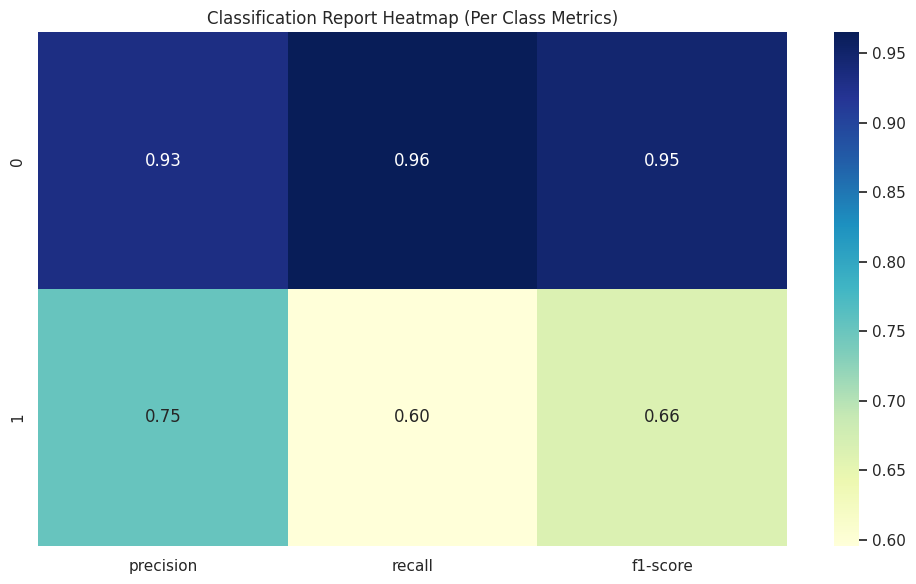

precision    recall  f1-score      support
0              0.930569  0.965000  0.947472  1000.000000
1              0.751773  0.595506  0.664577   178.000000
accuracy       0.909168  0.909168  0.909168     0.909168
macro avg      0.841171  0.780253  0.806024  1178.000000
weighted avg   0.903552  0.909168  0.904725  1178.000000

In [253]:
clf_pipeline.evaluate_model()

INFO: Performing SHAP analysis...
INFO: Binary classification or regression detected.


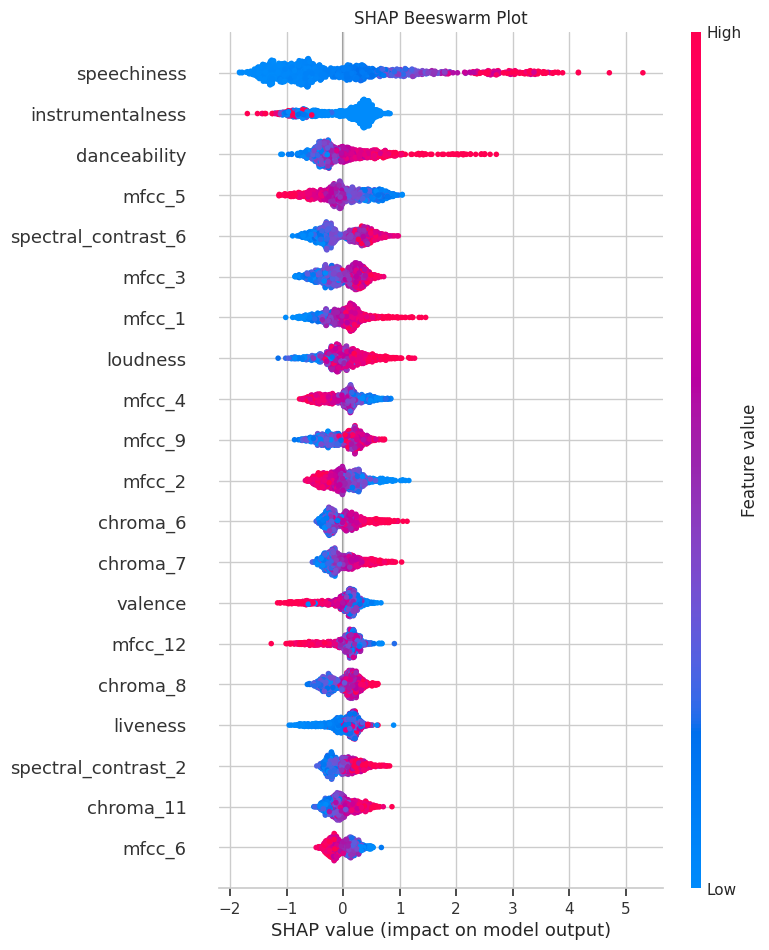

INFO: Generating feature importance bar plot...


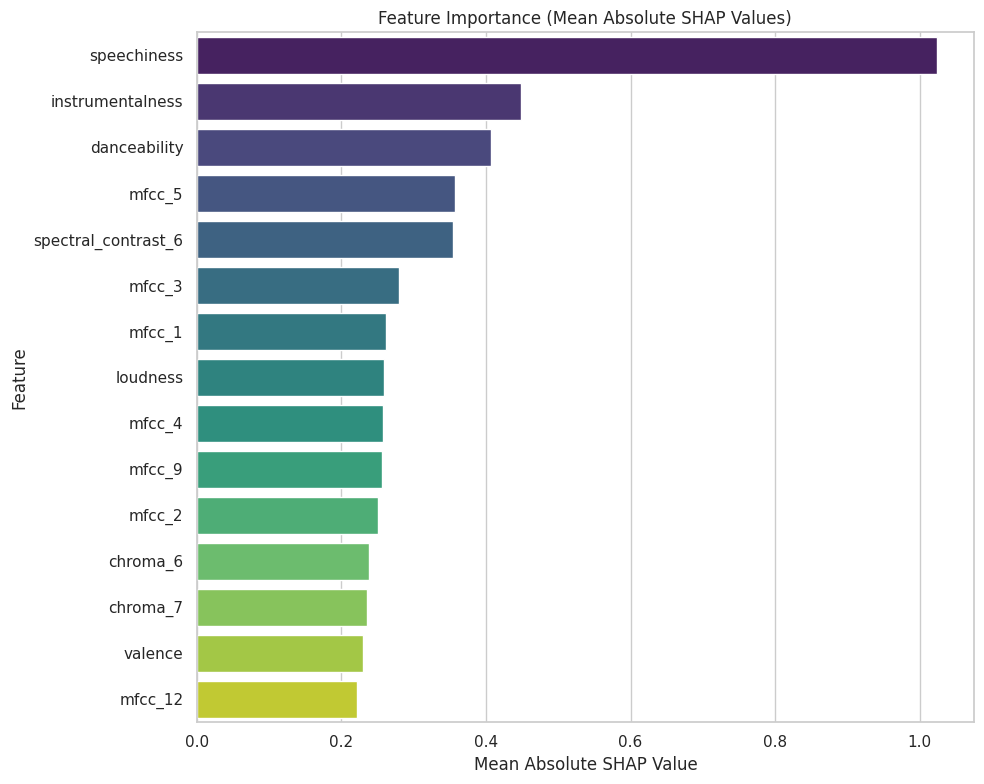

In [254]:
clf_pipeline.perform_shap_analysis()

# Genre-Specific Analysis
Objective: Investigate which acoustic or textual features dominate specific genres.

In [343]:
target = 'genre'

In [344]:
cat_acoustic_features

['key', 'mode', 'time_signature']

In [ ]:
spotify_features = ['popularity', 'explicit',
       'album_release_year', 'duration_ms', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature']

lyrics_features = ['unique_word_count',
       'sentiment_polarity', 'sentiment_subjectivity', 'noun_ratio',
       'verb_ratio', 'vader_compound', 'repetition_count', 'language', 'genre',
       'lexical_richness', 'semantic_depth', 'syntactic_complexity',
       'rhyme_density', 'sentiment_variability', 'linguistic_uniqueness',
       'flesch_reading_ease', 'gunning_fog', 'dale_chall', 'type_token_ratio', 'word_count']

tfidf_features = [ f for f in df.columns if f.startswith("tfidf_") ]


audio_extracted_features = ['mfcc_1', 'mfcc_2',
       'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9',
       'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'chroma_1', 'chroma_2',
       'chroma_3', 'chroma_4', 'chroma_5', 'chroma_6', 'chroma_7', 'chroma_8',
       'chroma_9', 'chroma_10', 'chroma_11', 'chroma_12',
       'spectral_contrast_1', 'spectral_contrast_2', 'spectral_contrast_3',
       'spectral_contrast_4', 'spectral_contrast_5', 'spectral_contrast_6',
       'spectral_contrast_7', 'tempo_extracted', 'zcr']

In [ ]:
clf_pipeline = OptimalClassificationPipeline(
    df.dropna(subset=[target]),
    target_column=target,
    num_features=spotify_features + lyrics_features + tfidf_features + audio_extracted_features,
    cat_features=cat_acoustic_features,
    n_trials=10,
    param_grid={
        "iterations": [500, 1000],
        "depth": [4, 6, 8],
        "learning_rate": (0.01, 0.1),
        "l2_leaf_reg": (1, 10),
    },
    cache_path="catboost_optuna.db"
)
clf_pipeline.get_pipeline()

In [ ]:
clf_pipeline.split()
clf_pipeline.train_model()

In [ ]:
clf_pipeline.model.training_results

In [ ]:
clf_pipeline.evaluate_model()

In [ ]:
clf_pipeline.perform_shap_analysis()

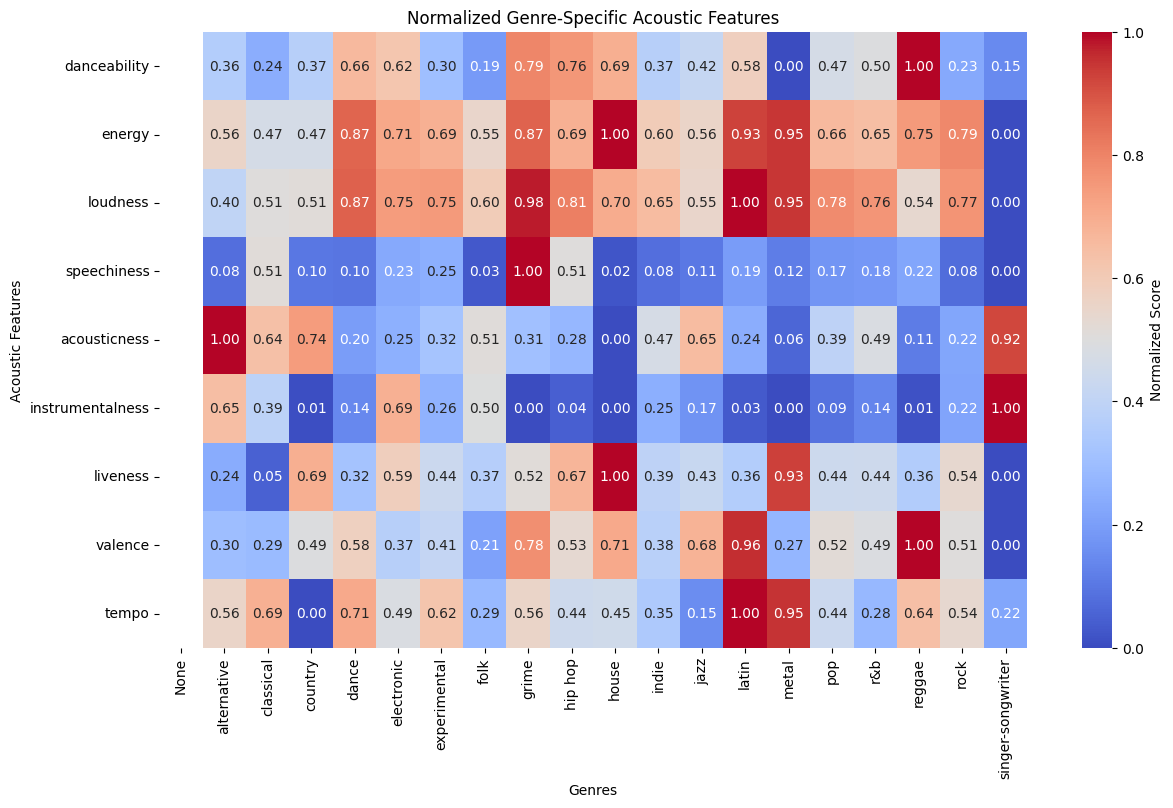

In [91]:
from sklearn.preprocessing import MinMaxScaler

# Select only the relevant features for normalization
features = ['danceability', 'energy', 'loudness', 'speechiness', 
            'acousticness', 'instrumentalness', 'liveness', 
            'valence', 'tempo']

# Group by genre and calculate mean acoustic features
genre_means = df.groupby('genre')[features].mean()

# Normalize each feature across genres using MinMaxScaler
scaler = MinMaxScaler()
normalized_genre_means = pd.DataFrame(scaler.fit_transform(genre_means), 
                                      columns=genre_means.columns, 
                                      index=genre_means.index)

# Heatmap to visualize normalized dominant features
plt.figure(figsize=(14, 8))
sns.heatmap(normalized_genre_means.T, cmap="coolwarm", annot=True, fmt=".2f", cbar_kws={'label': 'Normalized Score'})
plt.title("Normalized Genre-Specific Acoustic Features")
plt.xlabel("Genres")
plt.ylabel("Acoustic Features")
plt.show()


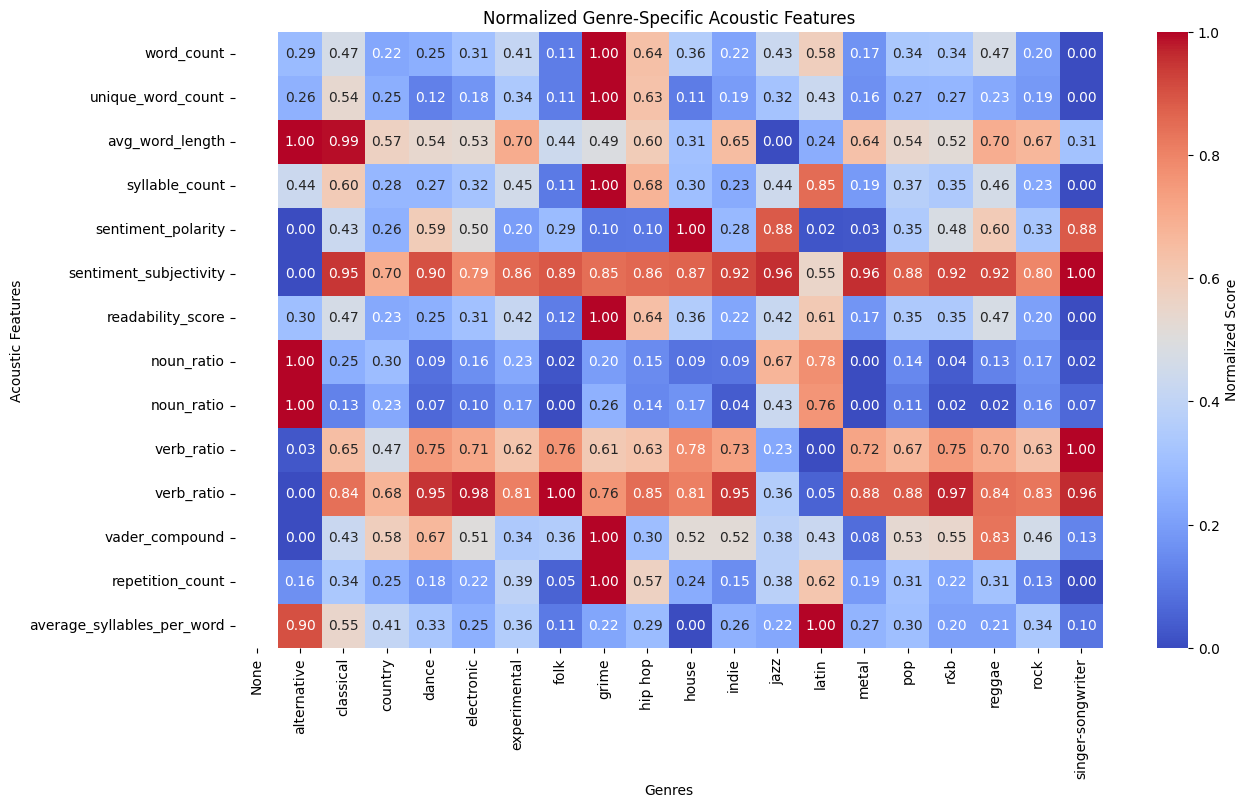

In [93]:
from sklearn.preprocessing import MinMaxScaler

genre_means = df.groupby('genre')[lyrics_features].mean()

# Normalize each feature across genres using MinMaxScaler
scaler = MinMaxScaler()
normalized_genre_means = pd.DataFrame(scaler.fit_transform(genre_means), 
                                      columns=genre_means.columns, 
                                      index=genre_means.index)

# Heatmap to visualize normalized dominant features
plt.figure(figsize=(14, 8))
sns.heatmap(normalized_genre_means.T, cmap="coolwarm", annot=True, fmt=".2f", cbar_kws={'label': 'Normalized Score'})
plt.title("Normalized Genre-Specific Acoustic Features")
plt.xlabel("Genres")
plt.ylabel("Acoustic Features")
plt.show()

# Co-occurrence Patterns in Textual Data
Objective: Perform topic modeling or co-occurrence analysis to uncover common themes or phrases in lyrics.

In [10]:
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.matutils import Sparse2Corpus
import pyLDAvis.gensim_models
import pyLDAvis
from sklearn.feature_extraction.text import CountVectorizer

lyrics_texts = df[df.language == 'english']['preprocessed_lyrics'].dropna()
vectorizer = CountVectorizer(max_features=1000)
X_lyrics = vectorizer.fit_transform(lyrics_texts)

corpus = Sparse2Corpus(X_lyrics, documents_columns=False)
vocab = vectorizer.get_feature_names_out()
id2word = Dictionary([vocab])

lda_model = LdaModel(corpus=corpus, num_topics=5, id2word=id2word, random_state=42, passes=10)

pyLDAvis.enable_notebook()
lda_vis = pyLDAvis.gensim_models.prepare(
    topic_model=lda_model,
    corpus=corpus,
    dictionary=id2word
)

pyLDAvis.display(lda_vis)

In [18]:
doc_topics = lda_model.get_document_topics(corpus, minimum_probability=0.0)

# Create a list of dominant topics
dominant_topics = []
for topics in doc_topics:
    dominant_topic, _ = max(topics, key=lambda x: x[1])  # Extract only the dominant topic
    dominant_topics.append(dominant_topic)

# Add the dominant topics as a new column to the original dataframe
df.loc[lyrics_texts.index, 'topic'] = dominant_topics

df[['title', 'topic']].head()


title  topic
0            skinny love    1.0
1              deathwish    1.0
2                   iris    3.0
3  don't dream it's over    1.0
4    undisclosed desires    3.0

In [19]:
df.topic.value_counts()

topic
3.0    1477
1.0    1463
2.0     668
4.0     519
0.0     516
Name: count, dtype: int64

/home/krystian/Python/VENVS/jupyter310/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/krystian/Python/VENVS/jupyter310/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/krystian/Python/VENVS/jupyter310/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


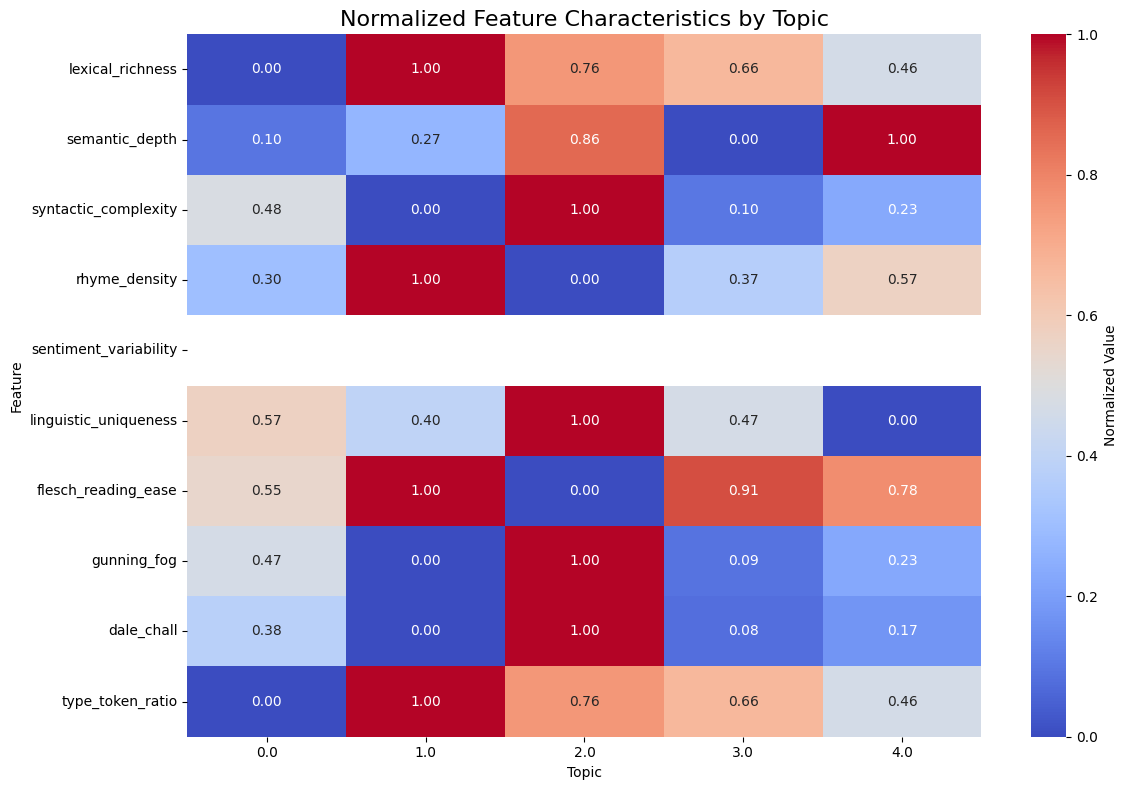

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Select the features to analyze and the topic column
lyrical_features = [
    'lexical_richness', 'semantic_depth', 'syntactic_complexity',
    'rhyme_density', 'sentiment_variability', 'linguistic_uniqueness',
    'flesch_reading_ease', 'gunning_fog', 'dale_chall', 'type_token_ratio'
]

# Ensure 'topic' column exists in the dataframe
assert 'topic' in df.columns, "The dataframe must have a 'topic' column."

# Group songs by topic and compute mean feature values
topic_features = df.groupby('topic')[lyrical_features].mean()

# Normalize features (optional, for better comparability)
normalized_topic_features = (topic_features - topic_features.min()) / (topic_features.max() - topic_features.min())

# Plot heatmap for visual comparison
plt.figure(figsize=(12, 8))
sns.heatmap(normalized_topic_features.T, annot=True, cmap="coolwarm", fmt=".2f", cbar_kws={'label': 'Normalized Value'})
plt.title("Normalized Feature Characteristics by Topic", fontsize=16)
plt.xlabel("Topic")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


### Correlating topics with genres

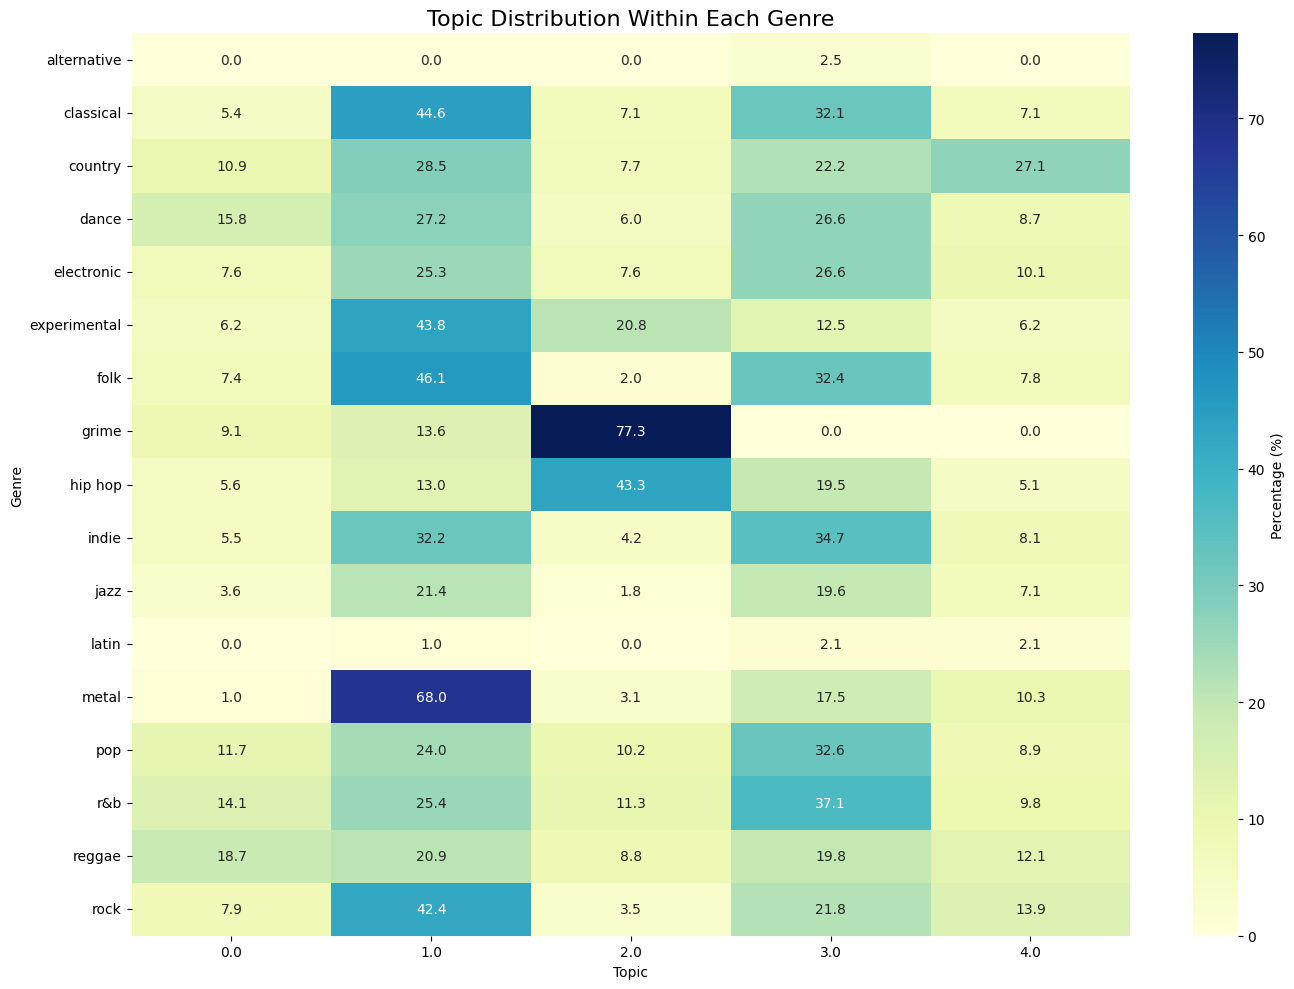

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Check if the dataframe has the required columns
assert 'topic' in df.columns, "The dataframe must have a 'topic' column."
assert 'genre' in df.columns, "The dataframe must have a 'genre' column."

# Group by genre and topic to count occurrences
genre_topic_counts = df.groupby(['genre', 'topic']).size().reset_index(name='count')

# Calculate total songs per genre
genre_totals = df['genre'].value_counts().reset_index()
genre_totals.columns = ['genre', 'total_songs']

# Merge totals with counts
genre_topic_counts = genre_topic_counts.merge(genre_totals, on='genre')

# Calculate the percentage of each genre's songs in each topic
genre_topic_counts['percentage'] = (genre_topic_counts['count'] / genre_topic_counts['total_songs']) * 100

# Pivot the data for heatmap visualization
genre_topic_matrix = genre_topic_counts.pivot(index='genre', columns='topic', values='percentage').fillna(0)

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(genre_topic_matrix, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Percentage (%)'})
plt.title("Topic Distribution Within Each Genre", fontsize=16)
plt.xlabel("Topic")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

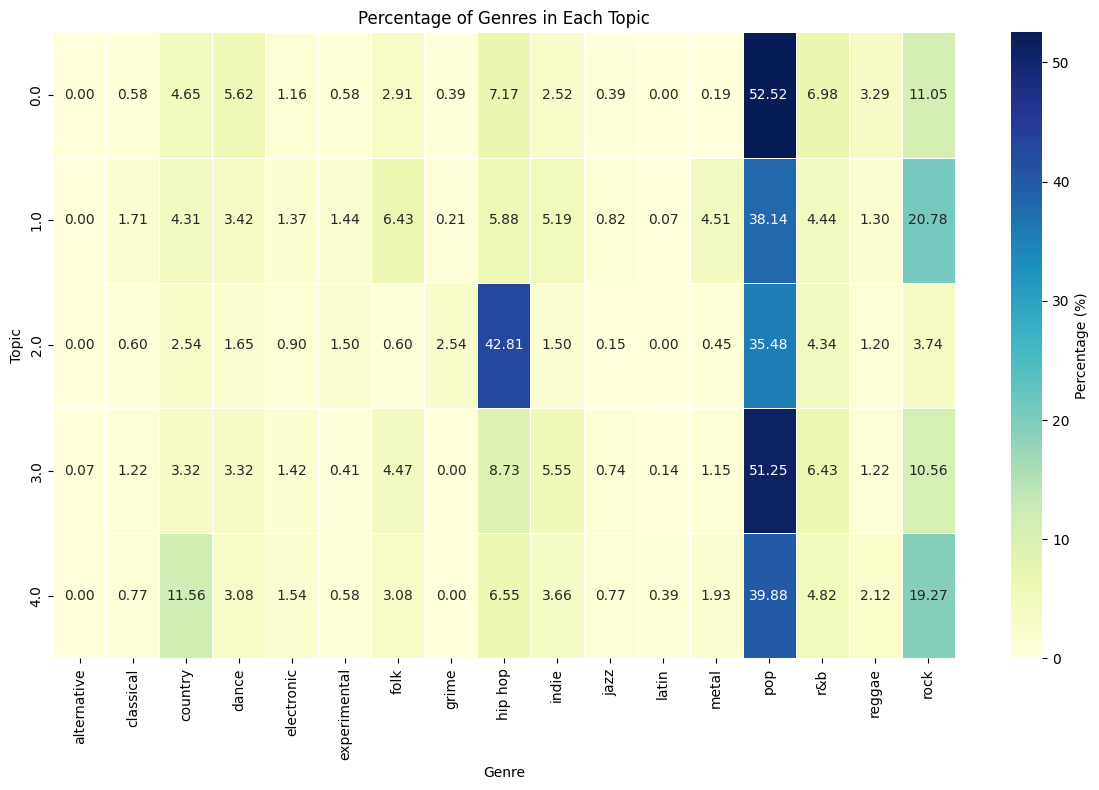

In [33]:
# Assuming your DataFrame is named df and has 'topic' and 'genre' columns
topic_genre_crosstab = pd.crosstab(df['topic'], df['genre'])

# Normalize the cross-tabulation to show percentages of genres within topics
topic_genre_percentage = (topic_genre_crosstab.div(topic_genre_crosstab.sum(axis=1), axis=0) * 100).round(2)

# Plot the heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(
    topic_genre_percentage, 
    annot=True, 
    fmt=".2f",  # Format the numbers with 2 decimal places
    cmap="YlGnBu", 
    linewidths=0.5,
    cbar_kws={"label": "Percentage (%)"}
)

plt.title("Percentage of Genres in Each Topic")
plt.ylabel("Topic")
plt.xlabel("Genre")
plt.tight_layout()
plt.show()


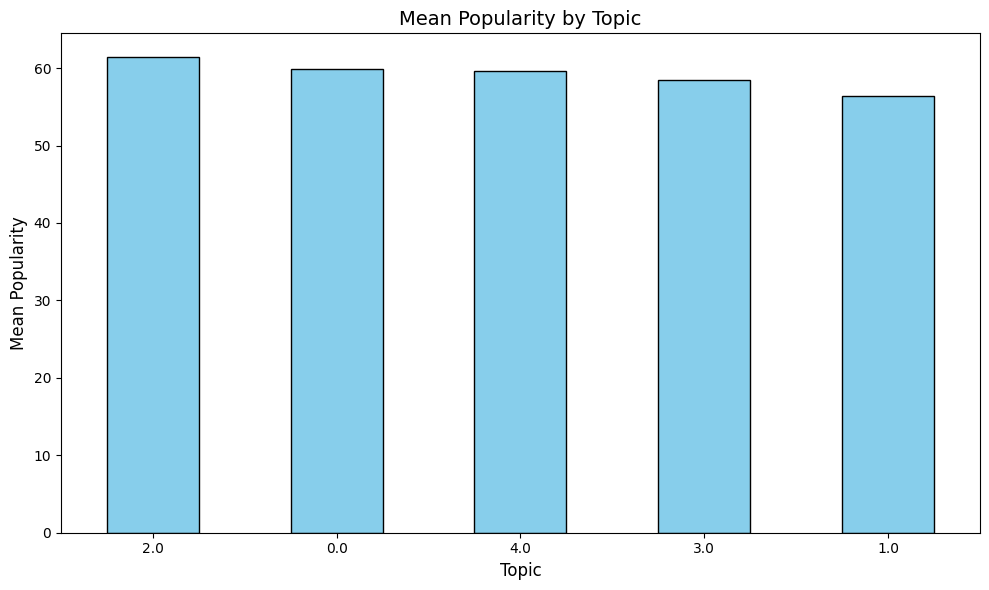

topic
2.0    61.414671
0.0    59.897287
4.0    59.595376
3.0    58.513202
1.0    56.375256
Name: popularity, dtype: float64

In [34]:
# Compute mean popularity for each topic
topic_popularity = df.groupby('topic')['popularity'].mean().sort_values(ascending=False)

# Plot the mean popularity for each topic
plt.figure(figsize=(10, 6))
topic_popularity.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Mean Popularity by Topic", fontsize=14)
plt.xlabel("Topic", fontsize=12)
plt.ylabel("Mean Popularity", fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

topic_popularity


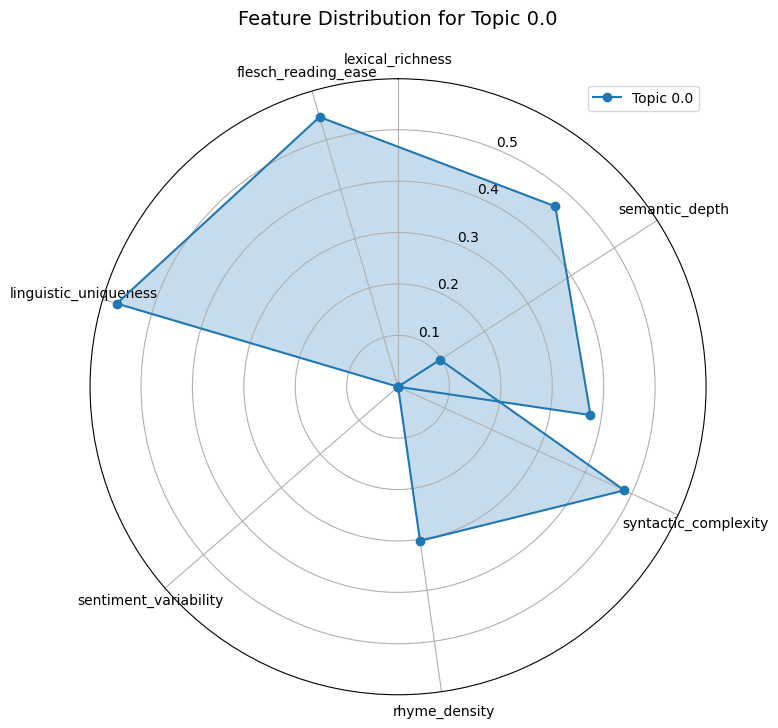

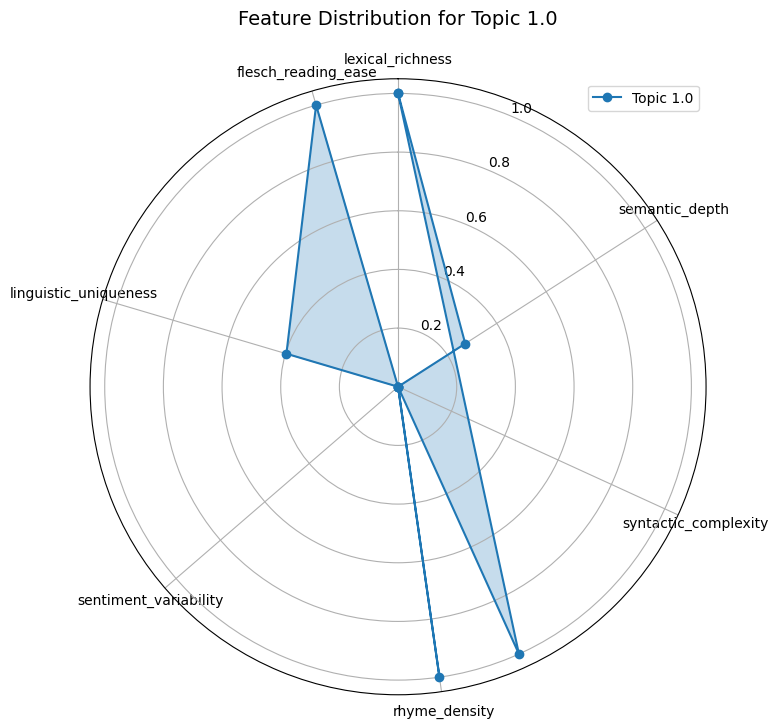

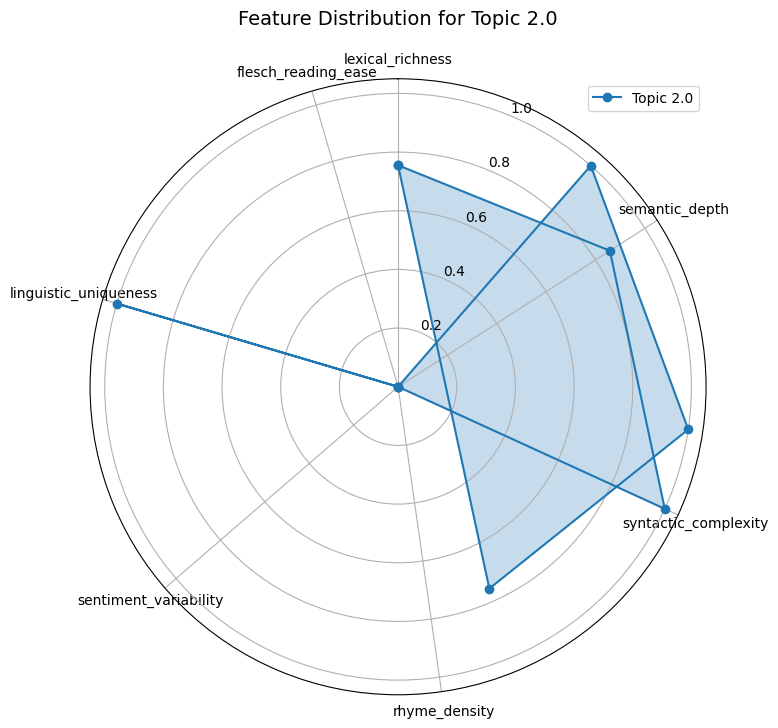

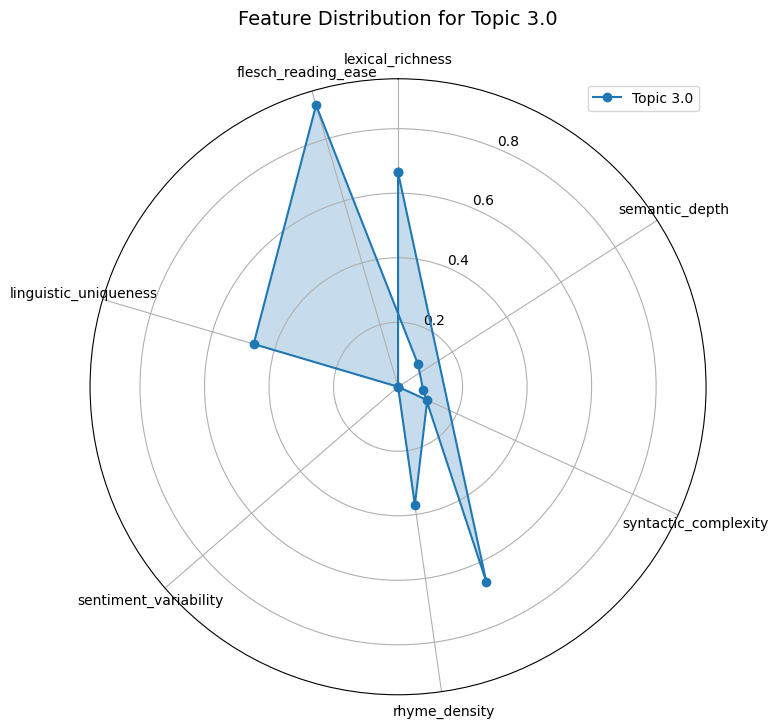

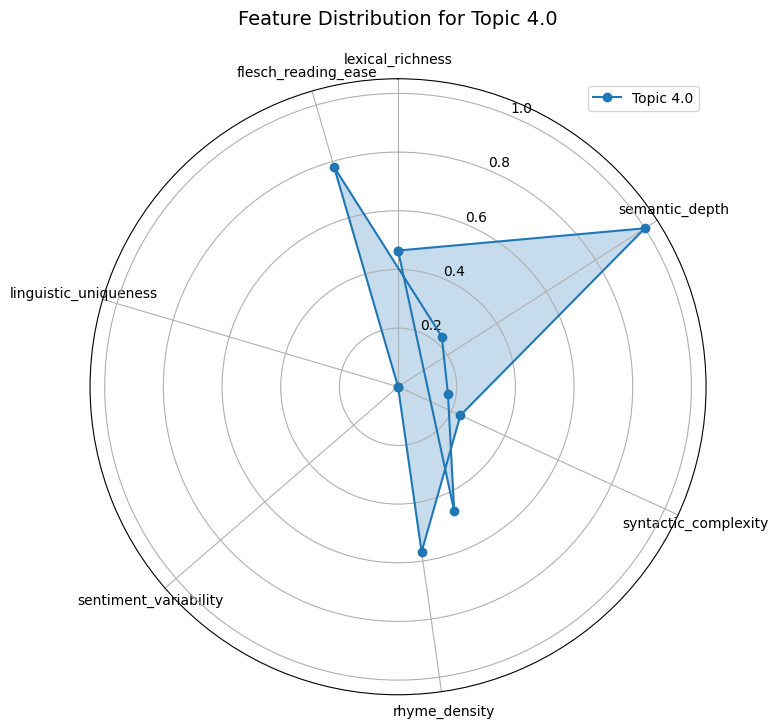

In [41]:
from math import pi
from sklearn.preprocessing import MinMaxScaler

# Prepare data for radar charts with Min-Max scaling
topic_features = df.groupby('topic')[lyrical_features].mean()
scaler = MinMaxScaler()
topic_features_scaled = pd.DataFrame(scaler.fit_transform(topic_features), columns=topic_features.columns, index=topic_features.index)

for topic_id in topic_features_scaled.index:
    features = topic_features_scaled.loc[topic_id]
    labels = features.index.tolist()
    values = features.values.tolist()
    
    # Complete the loop for the radar chart
    values += values[:1]
    labels += [labels[0]]
    
    # Create radar plot
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.plot(labels, values, marker='o', label=f"Topic {topic_id}")
    ax.fill(labels, values, alpha=0.25)
    
    plt.title(f"Feature Distribution for Topic {topic_id}", fontsize=14, pad=20)
    plt.legend(loc="upper right")
    plt.show()


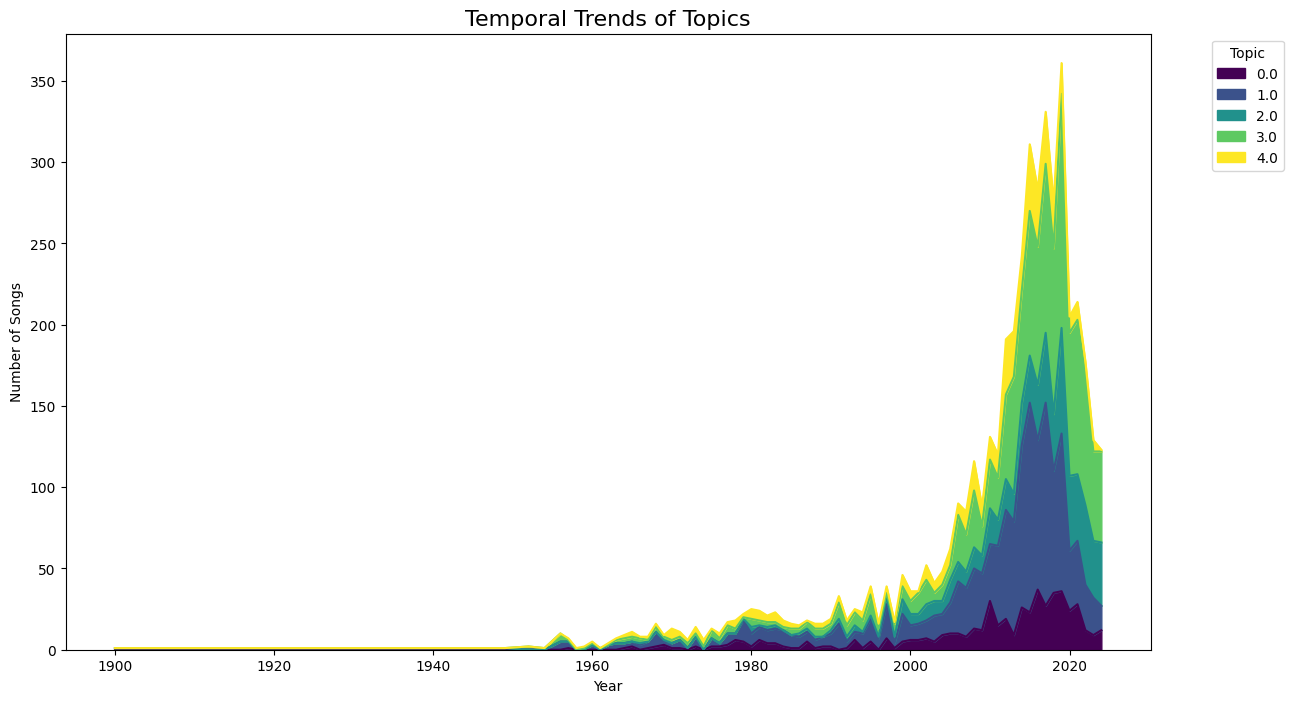

In [38]:
# Ensure your DataFrame has a 'year' column
# Group by year and topic
temporal_trends = df.groupby(['album_release_year', 'topic']).size().unstack(fill_value=0)

# Plot temporal trends
temporal_trends.plot(kind='area', stacked=True, figsize=(14, 8), colormap='viridis')
plt.title("Temporal Trends of Topics", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Number of Songs")
plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


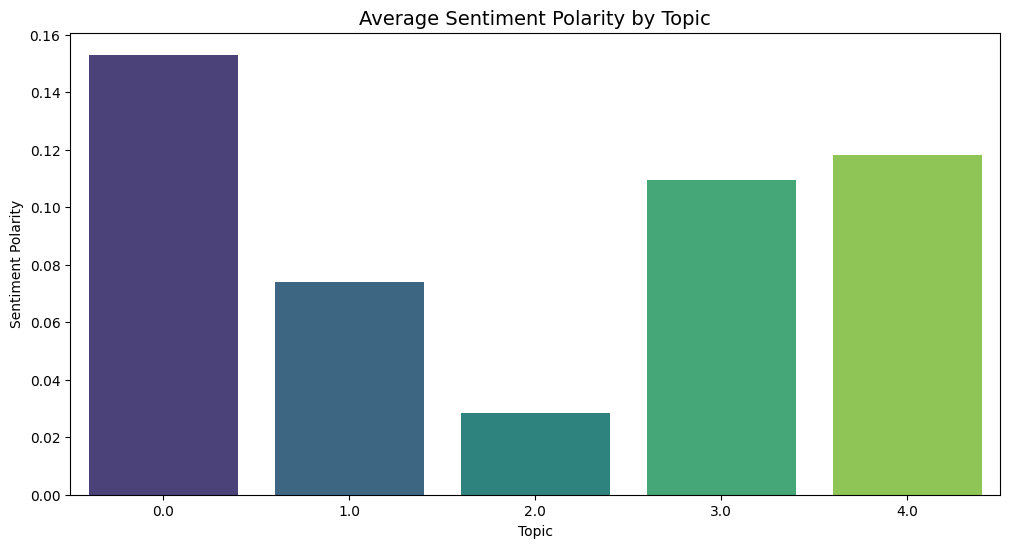

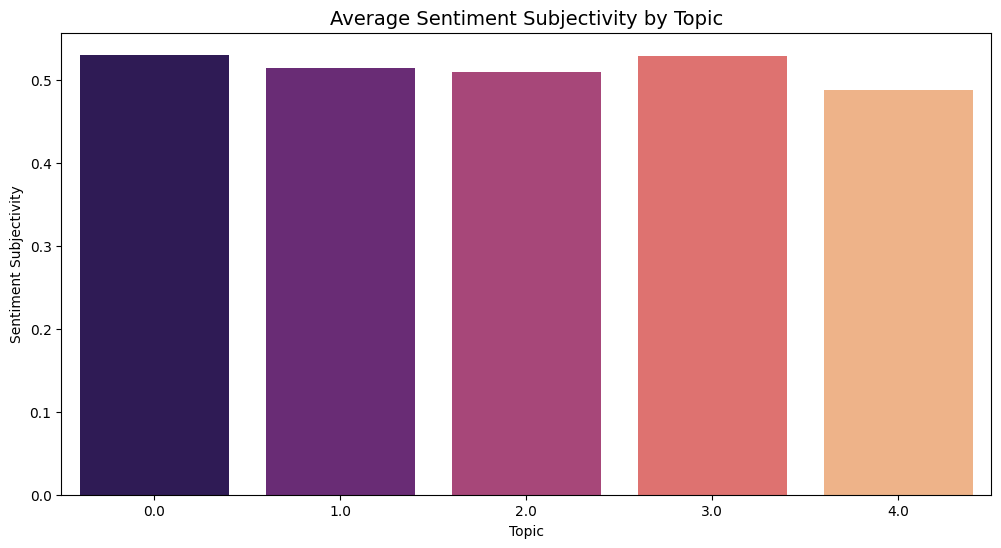

In [39]:
# Sentiment analysis grouped by topic
sentiment_data = df.groupby('topic')[['sentiment_polarity', 'sentiment_subjectivity']].mean()

plt.figure(figsize=(12, 6))
sns.barplot(data=sentiment_data.reset_index(), x='topic', y='sentiment_polarity', palette='viridis')
plt.title("Average Sentiment Polarity by Topic", fontsize=14)
plt.xlabel("Topic")
plt.ylabel("Sentiment Polarity")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=sentiment_data.reset_index(), x='topic', y='sentiment_subjectivity', palette='magma')
plt.title("Average Sentiment Subjectivity by Topic", fontsize=14)
plt.xlabel("Topic")
plt.ylabel("Sentiment Subjectivity")
plt.show()


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Compute average lyrical features per topic
lyrical_features_by_topic = df.groupby('topic')[lyrical_features].mean()

# Min-Max scale the features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(lyrical_features_by_topic)
scaled_features_df = pd.DataFrame(scaled_features, columns=lyrical_features, index=lyrical_features_by_topic.index)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    scaled_features_df, 
    annot=True, 
    fmt=".2f", 
    cmap="viridis", 
    cbar_kws={"label": "Scaled Feature Value"}
)
plt.title("Scaled Average Lyrical Features by Topic")
plt.xlabel("Lyrical Features")
plt.ylabel("Topic")
plt.show()